In [12]:

import glob
import F21DataLoader as dl
import f21_predict_base as base

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization

import logging

import torch

import importlib

importlib.reload(dl)
importlib.reload(base)

logger = logging.getLogger(__name__)

def load_dataset(datafiles, psbatchsize=100, ps_bins=None, limitsamplesize=None):
    # Create processor with desired number of worker threads
    processor = dl.F21DataLoader(max_workers=1, psbatchsize=psbatchsize, skip_ps=False, ps_bins=None, limitsamplesize=limitsamplesize, scale_ps=True)#, limitsamplesize=4)
        
    # Process all files and get results 
    results = processor.process_all_files(datafiles)
        
    # Access results
    #print(f'{results.keys()}')
    all_ks = results['ks']
    all_los = results['los']
    all_freq = results['freq_axis']
    all_ps = results['ps']
    #ps_std = results['ps_std']
    #ps_plus_std = all_ps + ps_std
    #ps_minus_std = all_ps - ps_std
    all_params = results['params']
    #plot_los(all_ps[0], freq_axis)
    """
    print(f"sample ks:{all_ks[0]}")
    print(f"sample ps:{all_ps[0,:]}")
    print(f"sample params:{all_params[0]}")
    print(f"sample los:{all_los[0]}")
    print(f"sample freq:{all_freq}")
    """
    #base.plot_los(all_los[:1], all_freq[0,:], showplots=True, saveplots = False, label=f"{all_params[0]}")
    #base.plot_power_spectra(all_ps[:1], all_ks[:1], all_params[:1], showplots=True, saveplots = False, label=f"{all_params[0]}")

    print(f"\nCombined data shape: {all_los.shape}")
    print(f"Combined parameters shape: {all_params.shape}")
    return (all_params, all_freq, all_los, all_ps, all_ks)


def logbin_power_spectrum_by_k(ks, ps):
    print(f"logbin_power_spectrum_by_k: original ks: {ks[0,:5]} .. {ks[0,-5:]}")
    print(f"original ps: {ps[0,:5]}..{ps[0,-5:]}")

    d_log_k_bins = 0.25
    log_k_bins = np.arange(-7.0-d_log_k_bins/2.,-3.+d_log_k_bins/2.,d_log_k_bins)

    k_bins = np.power(10.,log_k_bins)
    k_bins_cent = np.power(10.,log_k_bins+d_log_k_bins/2.)[:-1]
    print(k_bins_cent)

    binlist=np.zeros((ps.shape[0], len(k_bins_cent)))
    pslist=np.zeros((ps.shape[0], len(k_bins_cent)))
    for i, (row_ks, row_ps) in enumerate(zip(ks, ps)):
      for l in range(len(k_bins_cent)):
        mask = (row_ks >= k_bins[l]) & (row_ks < k_bins[l+1])
        # If any values fall in this bin, take their mean
        if np.any(mask):
            pslist[i,l] = np.mean(row_ps[mask])
        else:
            pslist[i,l] = 0.
        binlist[i,l] = k_bins_cent[l]

    print(f"logbin_power_spectrum_by_k: final ks: {binlist[0,:5]}..{binlist[0,-5:]}")
    print(f"final ps: {pslist[0,:5]}..{pslist[0,-5:]}")
    return binlist, pslist

def calculate_stats_torch(X, y, kernel_sizes):
    stat_calc = []

    for i,x in enumerate(X):
        row = []
        tensor_1d = torch.tensor(x)
        # Pad the tensor if length is not divisible by 3
        total_mean = torch.mean(tensor_1d)
        total_std = torch.std(tensor_1d, unbiased=False)
        #total_centered_x = tensor_1d - total_mean
        #total_skewness = torch.mean((total_centered_x / (total_std)) ** 3)

        row += [total_mean, total_std] # total_skewness

        for kernel_size in kernel_sizes:
            padding_needed = kernel_size - len(tensor_1d) % kernel_size
            if padding_needed > 0:
                tensor_1d = torch.nn.functional.pad(tensor_1d, (0, padding_needed))
            
            tensor_2d = tensor_1d.view(-1,kernel_size)

            means = torch.mean(tensor_2d, dim=1)
            std = torch.std(tensor_2d, dim=1, unbiased=False)

            centered_x = tensor_2d - means.unsqueeze(1)
            skewness = torch.mean((centered_x / (std.unsqueeze(1) + 1e-8)) ** 3, dim=1)

            mean_skew = torch.mean(skewness)
            std_skew = torch.std(skewness, unbiased=False)
            
            centered_skew = skewness - mean_skew
            skew2 = torch.mean((centered_skew / (std_skew.unsqueeze(0) + 1e-8)) ** 3)
                    
            min_skew = torch.min(skewness)

            skew5 = torch.mean((centered_x / (std.unsqueeze(1) + 1e-8)) ** 5)
            #skew7 = torch.mean((centered_x / (std.unsqueeze(1) + 1e-8)) ** 7)

            row += [mean_skew.item(), std_skew.item(), skew2.item(), min_skew.item()]
        
        stat_calc.append(row)

        if i < 5: logger.info(f'Stats for xHI={y[i, 0]} logfx={y[i, 1]}, kernel_size={kernel_size} = {row}')
    
    return np.array(stat_calc)

def plot_power_spectra_set(ps_set, ks, title, labels):
    print(f"shapes: {ps_set.shape},{ks.shape}")

    base.initplt()
    plt.title(f'{title}')
    for ps,label in zip(ps_set, labels):
        plt.loglog(ks[1:]*1e6, ps[1:], label=label, marker='o')
        #plt.scatter(ks[1:]*1e6, ps[1:], label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k (Hz$^{-1}$)')
    plt.ylabel(r'$kP_{21}$')
    plt.legend()
    plt.show()


In [3]:
import glob
files10so=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-1.00_xHI*_8kHz*.dat")
params10so, freq10so, los10so, ps10so, ks10so = load_dataset(files10so, psbatchsize=10, limitsamplesize=10, ps_bins=None)
files01sn=glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI*_uGMRT_8kHz_t500h*.dat")
params01sn, freq01sn, los01sn, ps01sn, ks01sn = load_dataset(files01sn, psbatchsize=10, limitsamplesize=10, ps_bins=None)
(paramsn, freqn, losn, psn, ksn) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noiseonly_21cmFAST_200Mpc_z6.0_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=10, limitsamplesize=10)
ksn_bin, psn_bin = logbin_power_spectrum_by_k(ksn, psn)



Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)

Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)

Combined data shape: (1, 2762)
Combined parameters shape: (1, 2)
logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 5.66937010e-08 9.13952657e-08 1.05313079e-07
 1.34125085e-07]..[3.72203516e-05 2.74043089e-05 3.85021949e-05 4.59992663e-05
 3.72233799e-05]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps:

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 3.46729714e-09 6.02507128e-09 1.59320498e-08
 1.45937418e-08]..[1.06896639e-08 1.10897125e-08 7.38987180e-09 1.73616952e-08
 6.94652034e-09]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 3.46729714e-09 6.02507128e-09
 1.52628958e-08]..[2.99376710e-08 2.82836923e-08 2.50930676e-08 1.67587914e-08
 0.00000000e+00]
min-max range: 0.004162702709436417-0.995766

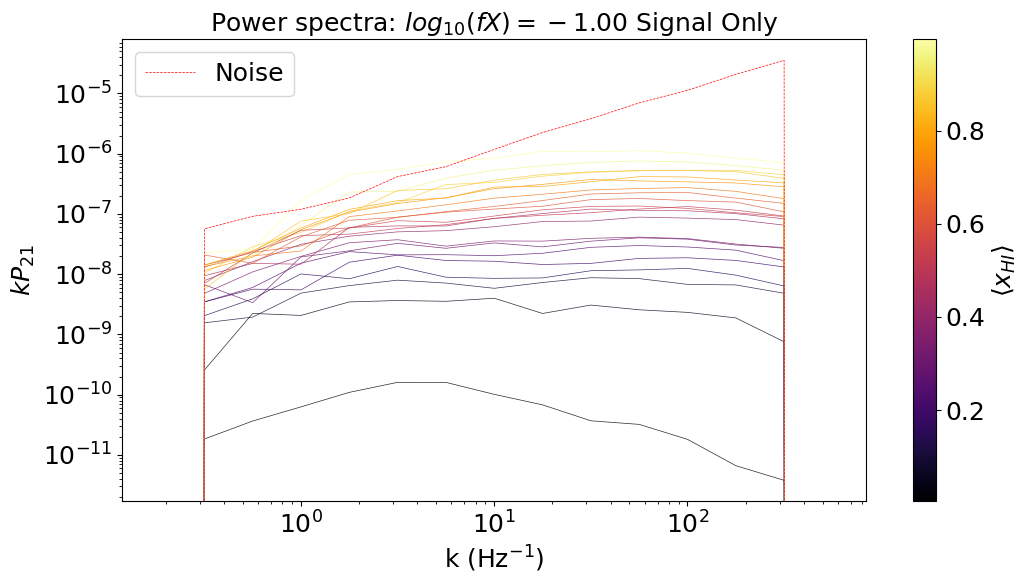

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 2.67453669e-08 5.90408112e-08 6.89573839e-08
 1.63632368e-07]..[5.42897446e-05 5.45354194e-05 5.70307910e-05 5.66620235e-05
 6.41977098e-05]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 2.67453669e-08 5.90408112e-08
 1.16294876e-07]..[6.85247410e-06 1.16941861e-05 2.04285940e-05 3.64620003e-05
 0.00000000e+00]
min-max range: 0.004162702709436417-0.995766

<Figure size 1200x600 with 0 Axes>

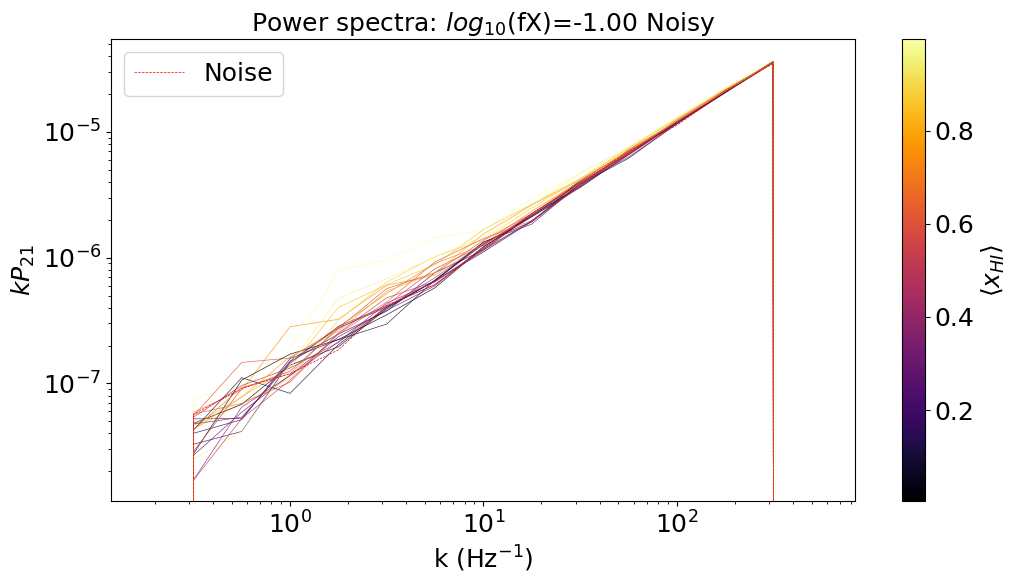

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 5.66937010e-08 9.13952657e-08 1.05313079e-07
 1.34125085e-07]..[3.72203516e-05 2.74043089e-05 3.85021949e-05 4.59992663e-05
 3.72233799e-05]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 5.66937010e-08 9.13952657e-08
 1.19719082e-07]..[6.97508972e-06 1.12773359e-05 2.07779529e-05 3.54893589e-05
 0.00000000e+00]
shapes: (21, 16),(1, 16),(21, 16)
min-max ra

<Figure size 1200x600 with 0 Axes>

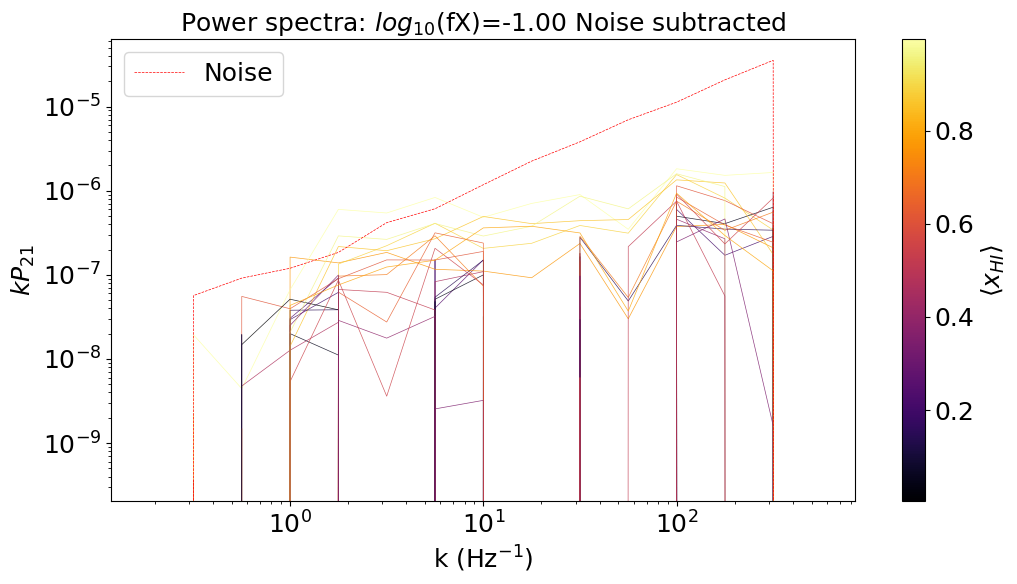

shapes: (4, 16),(16,)


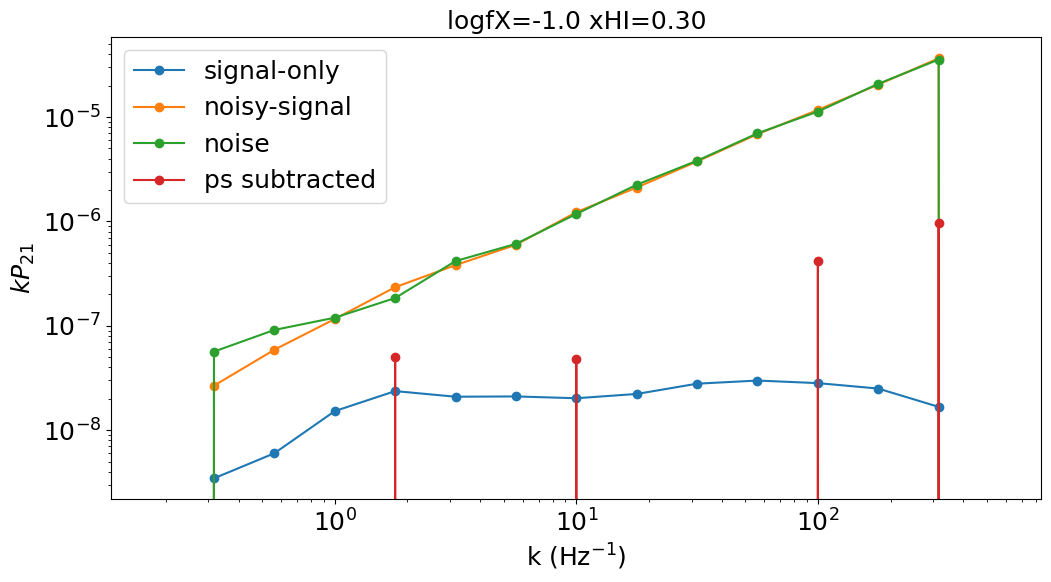

shapes: (4, 16),(16,)


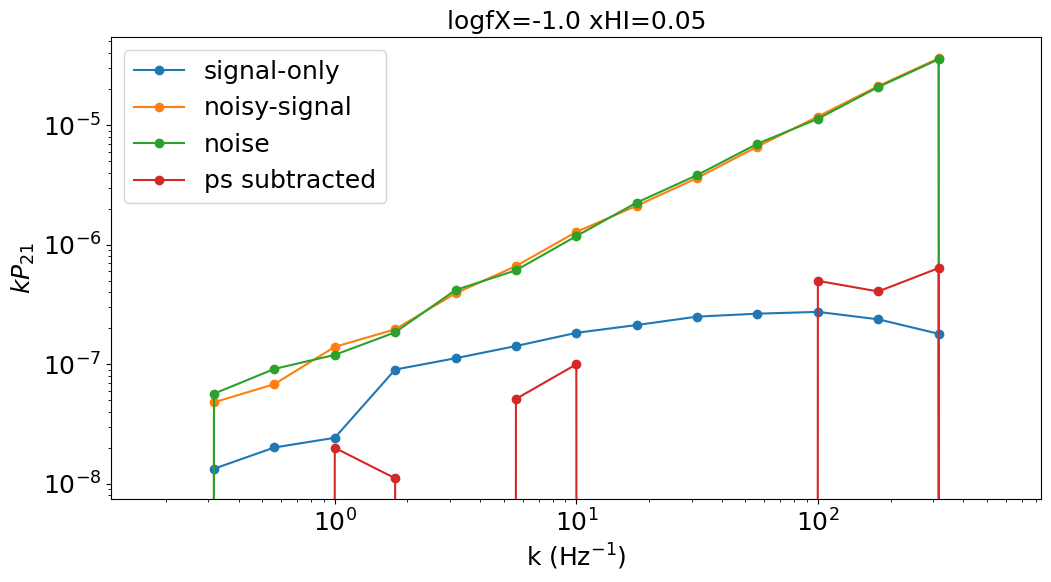

shapes: (4, 16),(16,)


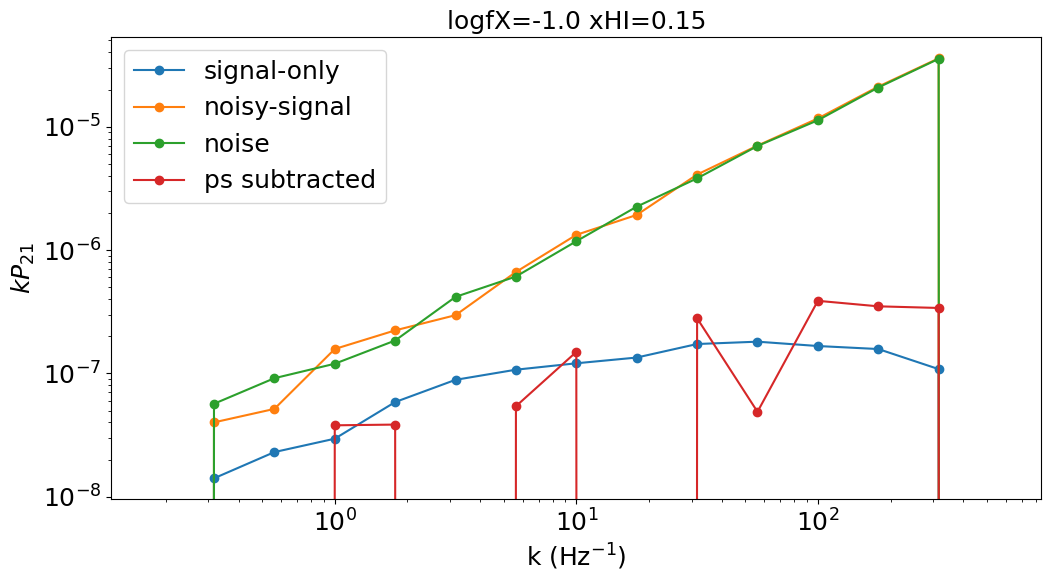

shapes: (4, 16),(16,)


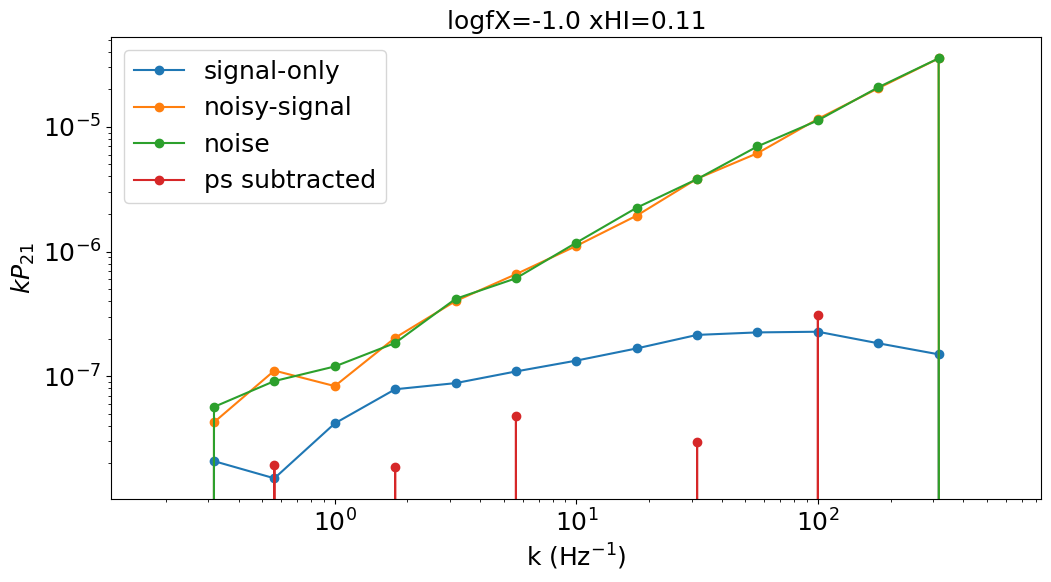

shapes: (4, 16),(16,)


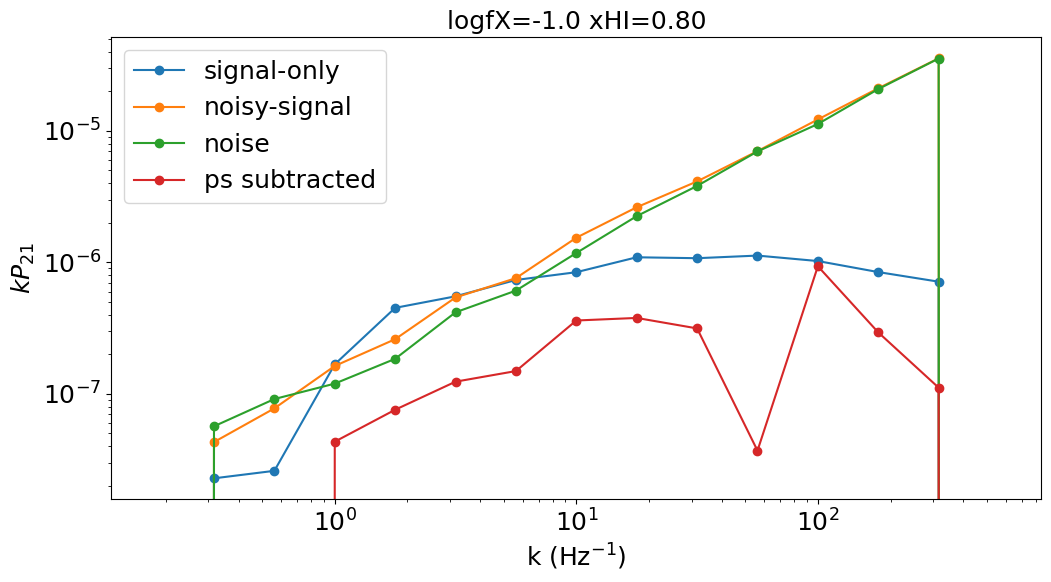

In [13]:
#base.plot_power_spectra(ps10so, ks10so, params10so, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=-1.00 Signal Only$")
ks10so_bin, ps10so_bin = logbin_power_spectrum_by_k(ks10so, ps10so)
base.plot_power_spectra(ps10so_bin, ks10so_bin, params10so, psn=psn_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=-1.00$ Signal Only")

#base.plot_power_spectra(ps01sn, ks01sn, params01sn, colorind=0, showplots=True, saveplots=False, label=r'$log_{10}$(fX)=-1.0 Noisy')
ks01sn_bin, ps01sn_bin = logbin_power_spectrum_by_k(ks01sn, ps01sn)
base.plot_power_spectra(ps01sn_bin, ks01sn_bin, params01sn, psn=psn_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-1.00 Noisy")

ksn_bin, psn_bin = logbin_power_spectrum_by_k(ksn, psn)
ps01_sub_bin = ps01sn_bin - psn_bin
print(f"shapes: {ps01sn_bin.shape},{psn_bin.shape},{ps01_sub_bin.shape}")
base.plot_power_spectra(ps01_sub_bin, ks01sn_bin, params01sn, psn=psn_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-1.00 Noise subtracted")
plot_power_spectra_set(np.vstack((ps10so_bin[0,:],ps01sn_bin[0,:],psn_bin,ps01_sub_bin[0,:])), ks01sn_bin[0,:], title=f"logfX=-1.0 xHI={params01sn[0,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps10so_bin[5,:],ps01sn_bin[5,:],psn_bin,ps01_sub_bin[5,:])), ks01sn_bin[5,:], title=f"logfX=-1.0 xHI={params01sn[5,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps10so_bin[10,:],ps01sn_bin[10,:],psn_bin,ps01_sub_bin[10,:])), ks01sn_bin[15,:], title=f"logfX=-1.0 xHI={params01sn[10,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps10so_bin[15,:],ps01sn_bin[15,:],psn_bin,ps01_sub_bin[15,:])), ks01sn_bin[15,:], title=f"logfX=-1.0 xHI={params01sn[15,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps10so_bin[20,:],ps01sn_bin[20,:],psn_bin,ps01_sub_bin[20,:])), ks01sn_bin[20,:], title=f"logfX=-1.0 xHI={params01sn[20,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])




Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)

Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)

Combined data shape: (1, 2762)
Combined parameters shape: (1, 2)
logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 3.16448869e-08 6.36783090e-08 9.50665230e-08
 1.36544853e-07]..[4.55238347e-05 4.55131199e-05 4.50273812e-05 4.25724612e-05
 4.66542982e-05]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps:

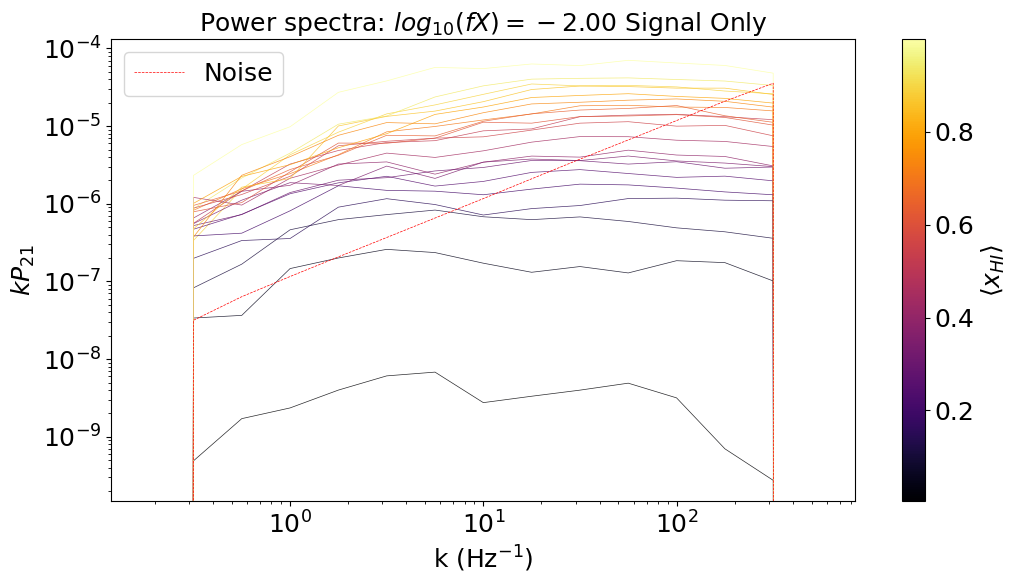

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 4.34780199e-07 1.23242844e-06 2.78363456e-06
 2.14330721e-06]..[4.73193884e-05 3.42015376e-05 5.74402865e-05 3.98933887e-05
 1.09004715e-04]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 4.34780199e-07 1.23242844e-06
 2.46347088e-06]..[1.66802508e-05 2.19303499e-05 3.14594883e-05 4.37869887e-05
 0.00000000e+00]
min-max range: 0.004337502643465996-0.999395

<Figure size 1200x600 with 0 Axes>

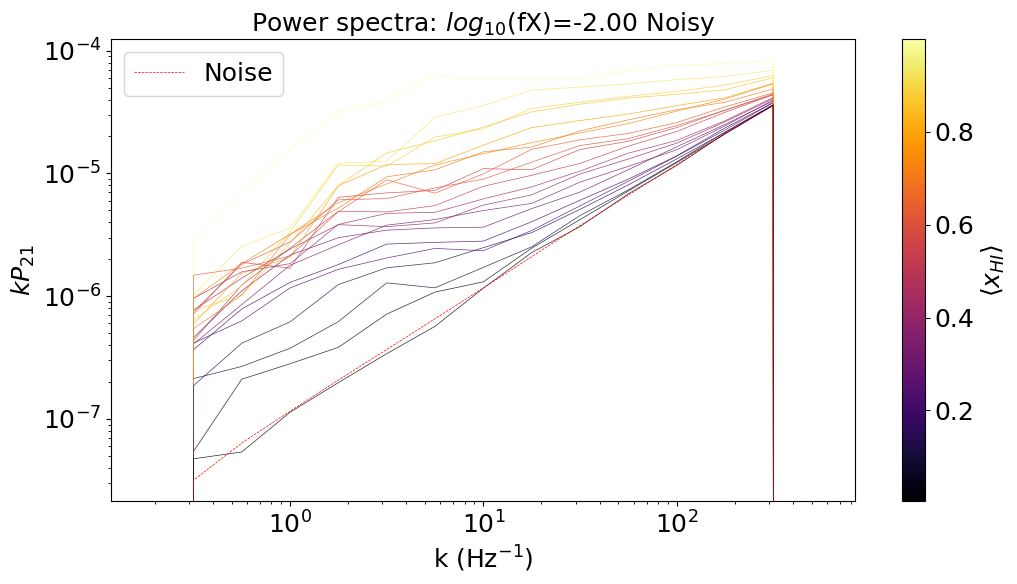

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 5.66937010e-08 9.13952657e-08 1.05313079e-07
 1.34125085e-07]..[3.72203516e-05 2.74043089e-05 3.85021949e-05 4.59992663e-05
 3.72233799e-05]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 5.66937010e-08 9.13952657e-08
 1.19719082e-07]..[6.97508972e-06 1.12773359e-05 2.07779529e-05 3.54893589e-05
 0.00000000e+00]
shapes: (21, 16),(1, 16),(21, 16)
shapes: (2

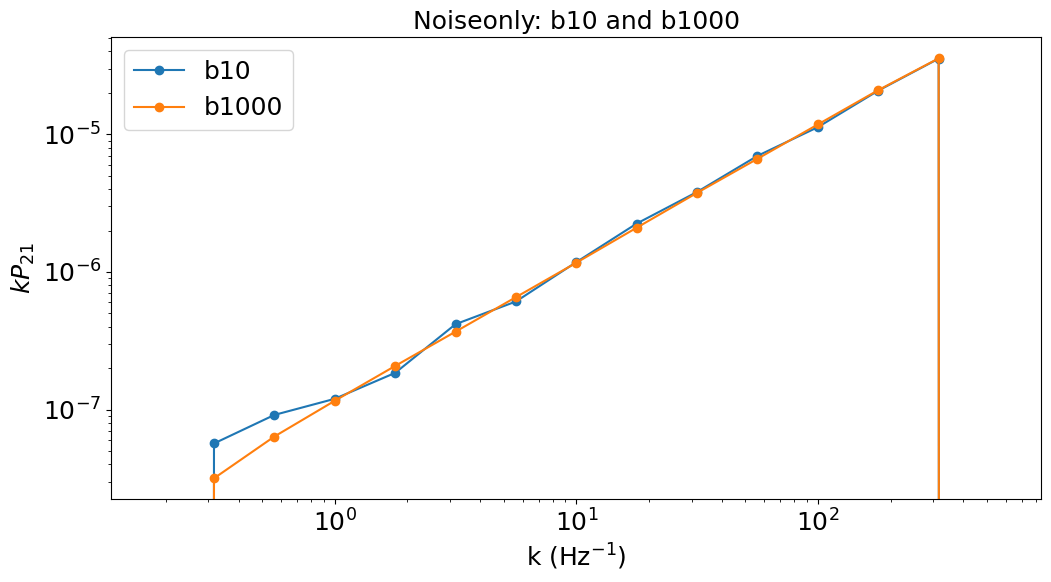

min-max range: 0.004337502643465996-0.9993957877159119


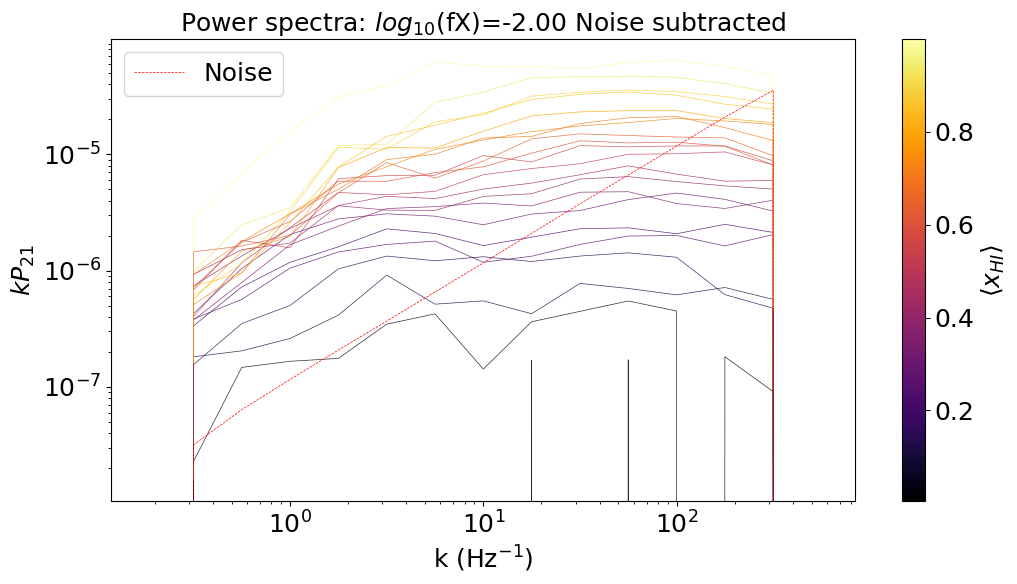

shapes: (4, 16),(16,)


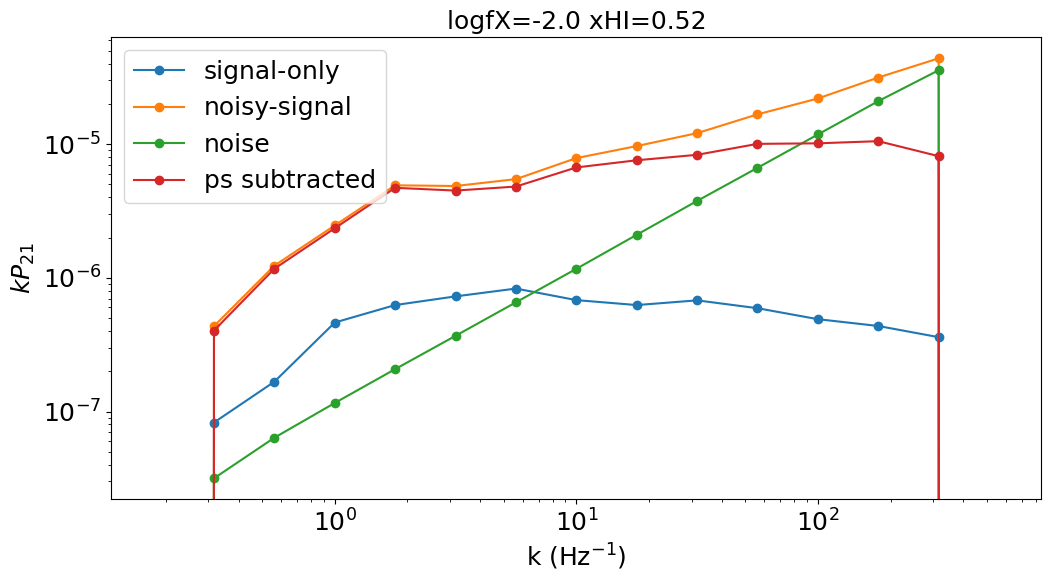

shapes: (4, 16),(16,)


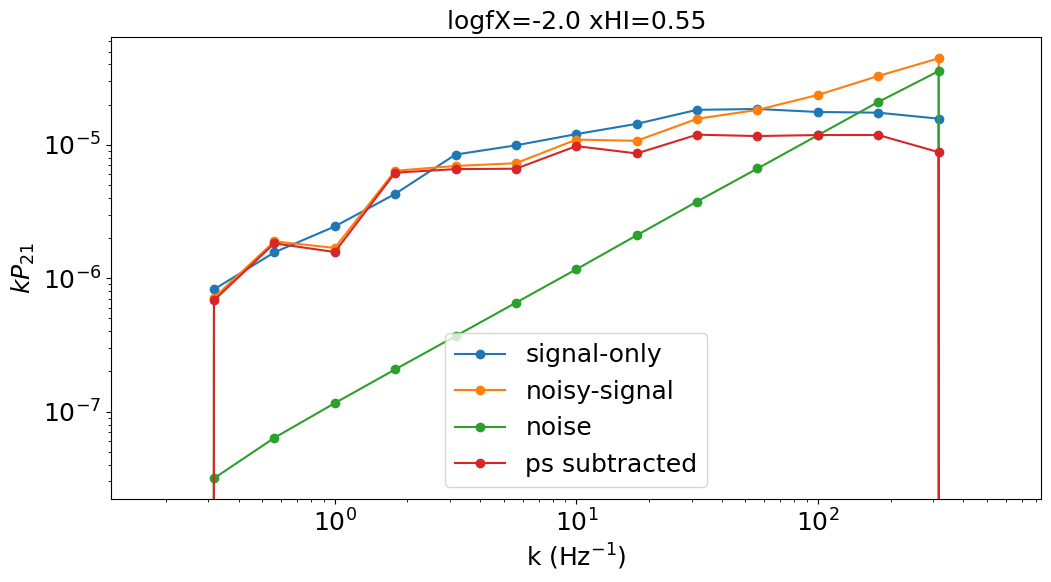

shapes: (4, 16),(16,)


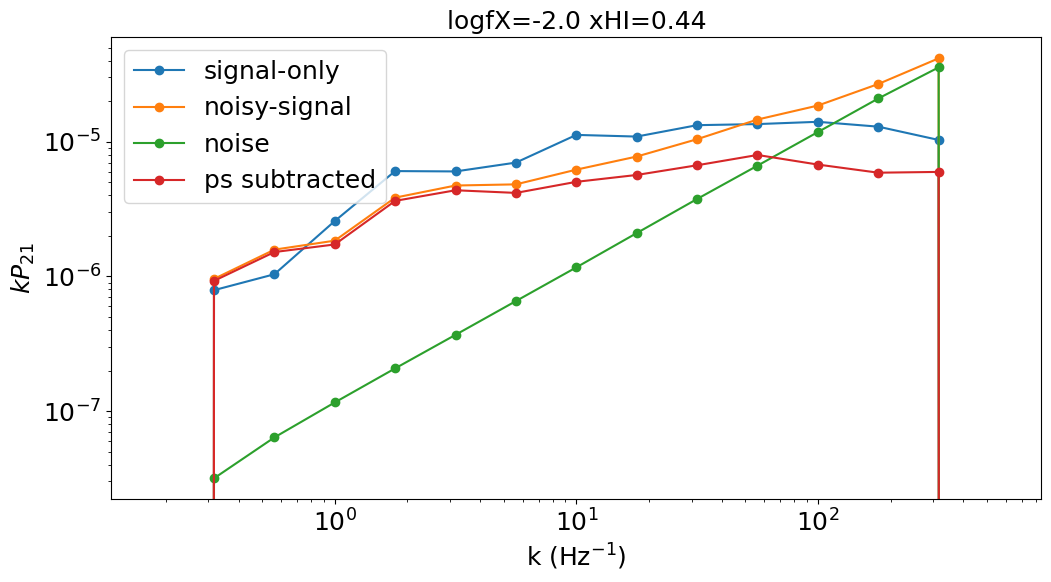

shapes: (4, 16),(16,)


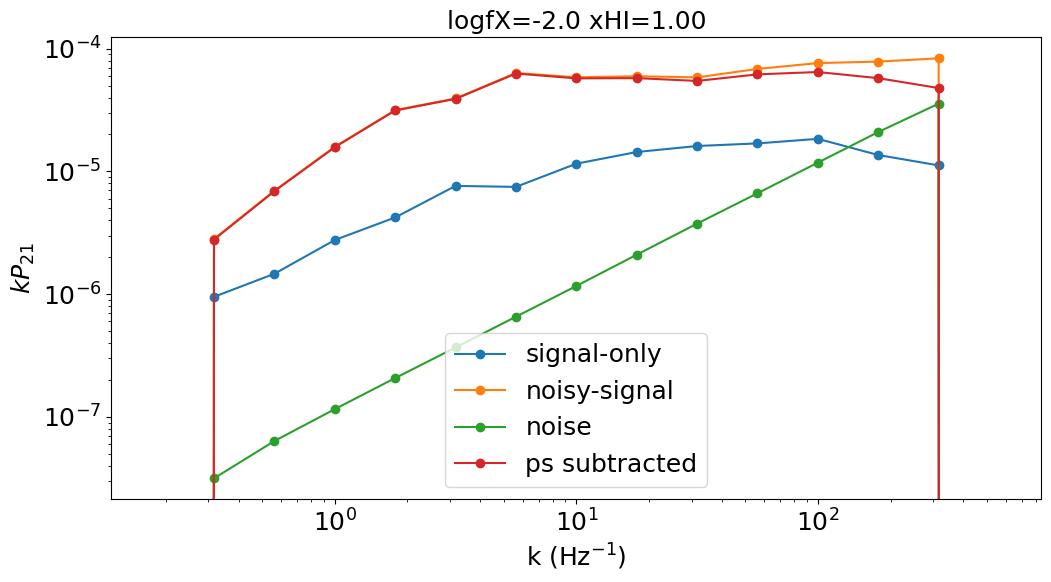

shapes: (4, 16),(16,)


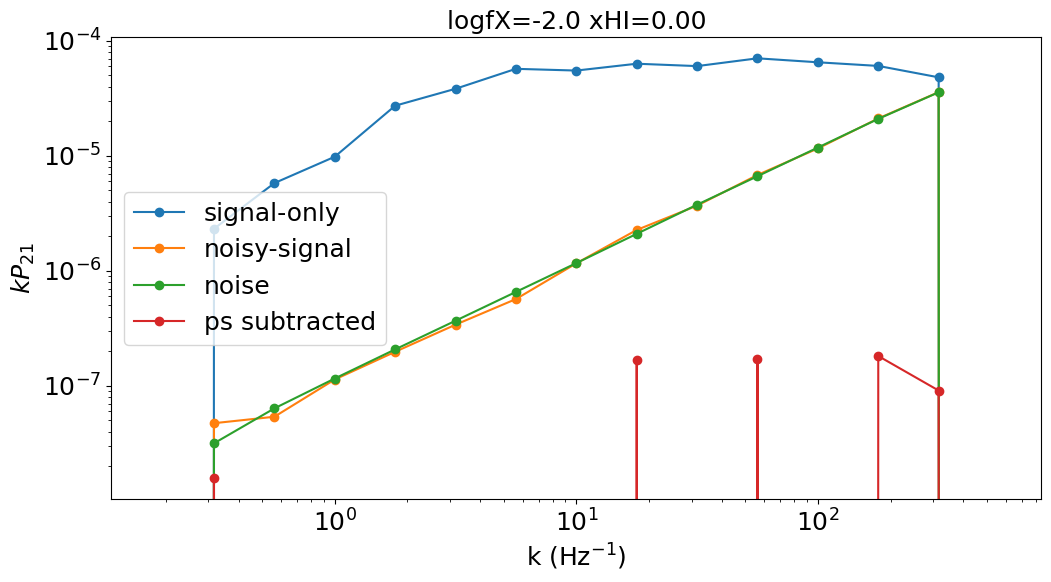

In [14]:
import glob
files20so=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI*_8kHz*.dat")
params20so, freq20so, los20so, ps20so, ks20so = load_dataset(files20so, psbatchsize=10, limitsamplesize=10, ps_bins=None)
files20sn=glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI*_uGMRT_8kHz_t500h*.dat")
params20sn, freq20sn, los20sn, ps20sn, ks20sn = load_dataset(files20sn, psbatchsize=10, limitsamplesize=10, ps_bins=None)
(paramsn1000, freqn1000, losn1000, psn1000, ksn1000) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noiseonly_21cmFAST_200Mpc_z6.0_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1000, limitsamplesize=1000)
ksn1000_bin, psn1000_bin = logbin_power_spectrum_by_k(ksn1000, psn1000)

#base.plot_power_spectra(ps20so, ks20so, params20so, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=-1.00 Signal Only$")
ks20so_bin, ps20so_bin = logbin_power_spectrum_by_k(ks20so, ps20so)
base.plot_power_spectra(ps20so_bin, ks20so_bin, params20so, psn=psn1000_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=-2.00$ Signal Only")

#base.plot_power_spectra(ps20sn, ks20sn, params20sn, colorind=0, showplots=True, saveplots=False, label=r'$log_{10}$(fX)=-1.0 Noisy')
ks20sn_bin, ps20sn_bin = logbin_power_spectrum_by_k(ks20sn, ps20sn)
base.plot_power_spectra(ps20sn_bin, ks20sn_bin, params20sn, psn=psn1000_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Noisy")

ksn_bin, psn_bin = logbin_power_spectrum_by_k(ksn, psn)
ps20_sub_bin = ps20sn_bin - psn1000_bin
print(f"shapes: {ps20sn_bin.shape},{psn_bin.shape},{ps20_sub_bin.shape}")
plot_power_spectra_set(np.vstack((psn_bin[0,:],psn1000_bin[0,:])), ksn_bin[0,:], title=f"Noiseonly: b10 and b1000", labels=["b10", "b1000"])
base.plot_power_spectra(ps20_sub_bin, ks20sn_bin, params20sn, psn=psn1000_bin[0,:], colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Noise subtracted")
plot_power_spectra_set(np.vstack((ps20so_bin[0,:],ps20sn_bin[0,:],psn1000_bin,ps20_sub_bin[0,:])), ks20sn_bin[0,:], title=f"logfX=-2.0 xHI={params20sn[0,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps20so_bin[5,:],ps20sn_bin[5,:],psn1000_bin,ps20_sub_bin[5,:])), ks20sn_bin[5,:], title=f"logfX=-2.0 xHI={params20sn[5,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps20so_bin[10,:],ps20sn_bin[10,:],psn1000_bin,ps20_sub_bin[10,:])), ks20sn_bin[15,:], title=f"logfX=-2.0 xHI={params20sn[10,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps20so_bin[15,:],ps20sn_bin[15,:],psn1000_bin,ps20_sub_bin[15,:])), ks20sn_bin[15,:], title=f"logfX=-2.0 xHI={params20sn[15,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])
plot_power_spectra_set(np.vstack((ps20so_bin[20,:],ps20sn_bin[20,:],psn1000_bin,ps20_sub_bin[20,:])), ks20sn_bin[20,:], title=f"logfX=-2.0 xHI={params20sn[20,0]:.2f}", labels=["signal-only", "noisy-signal","noise","ps subtracted"])



Combined data shape: (19, 2762)
Combined parameters shape: (19, 2)
min-max range: -4.0-1.0


ValueError: x and y must have same first dimension, but have shapes (1381,) and (0, 1382)

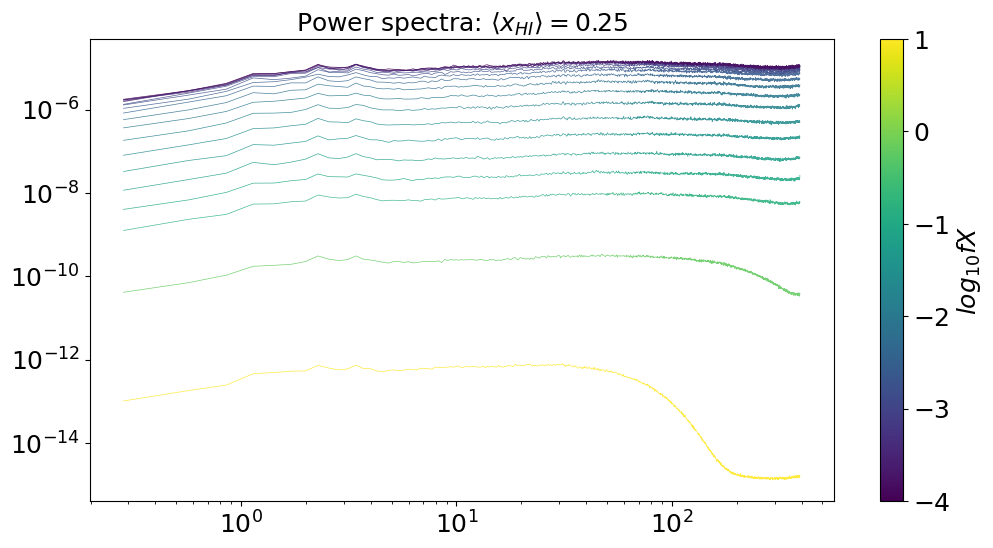

In [16]:
import glob
files025=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX*_xHI0.25_8kHz*.dat")
params025, freq025, los025, ps025, ks025 = load_dataset(files025, psbatchsize=1000, ps_bins=None)
base.plot_power_spectra(ps025, ks025, params025, psn=psn1000, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25$")


Combined data shape: (19000, 2762)
Combined parameters shape: (19000, 2)
min-max range: -4.0-1.0


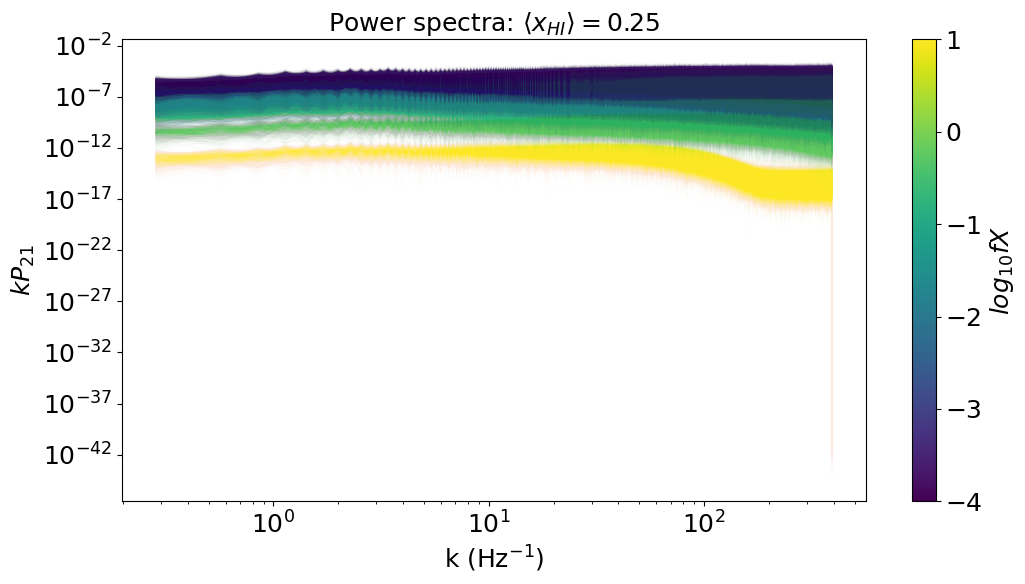

<Figure size 1200x600 with 0 Axes>

In [13]:
import glob
files025=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX*_xHI0.25_8kHz*.dat")
params025b1, freq025b1, los025b1, ps025b1, ks025b1 = load_dataset(files025, psbatchsize=1, ps_bins=None)
base.plot_power_spectra(ps025b1, ks025b1, params025b1, psn=psn1000, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25$")


Combined data shape: (19, 2762)
Combined parameters shape: (19, 2)
logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 4.05305306e-09 6.82461081e-09 1.03509658e-08
 1.72711606e-08]..[2.10382879e-08 2.18623254e-08 2.22557081e-08 2.29014907e-08
 2.66097062e-08]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 4.05305306e-09 6.82461081e-09
 1.38110632e-08]..[3.13584361e-08 2.96873329e-08 2.71291585e-08 2.204211

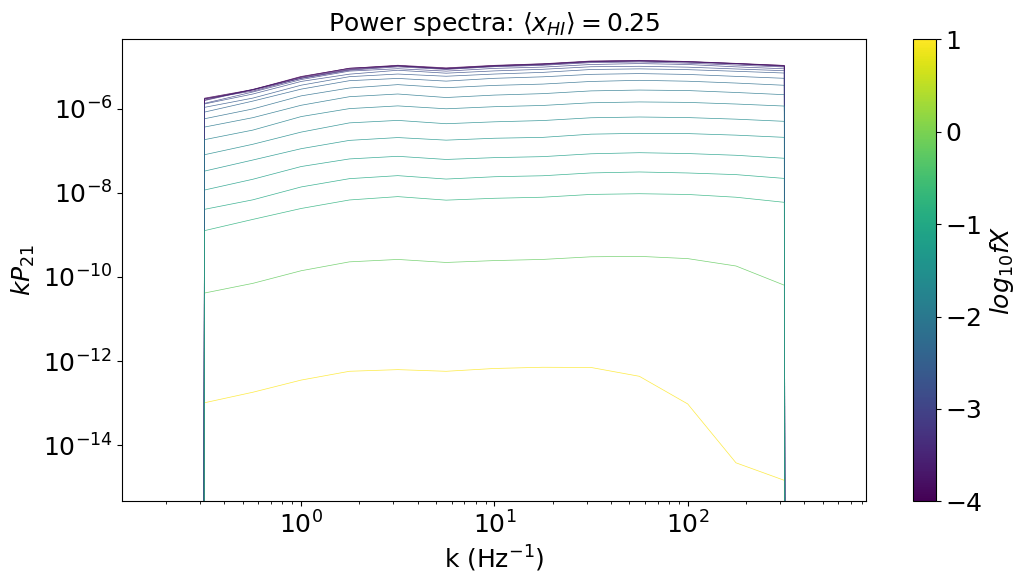

<Figure size 1200x600 with 0 Axes>

In [15]:
import glob
files025=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX*_xHI0.25_8kHz*.dat")
params025b1000, freq025b1000, los025b1000, ps025b1000, ks025b1000 = load_dataset(files025, psbatchsize=1000, ps_bins=None, limitsamplesize=None)
ks025_binb1000, ps025_binb1000 = logbin_power_spectrum_by_k(ks025b1000, ps025b1000)
print(ks025_binb1000[0])
base.plot_power_spectra(ps025_binb1000, ks025_binb1000, params025b1000, psn=psn1000, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25$")


min-max range: -4.0-1.0


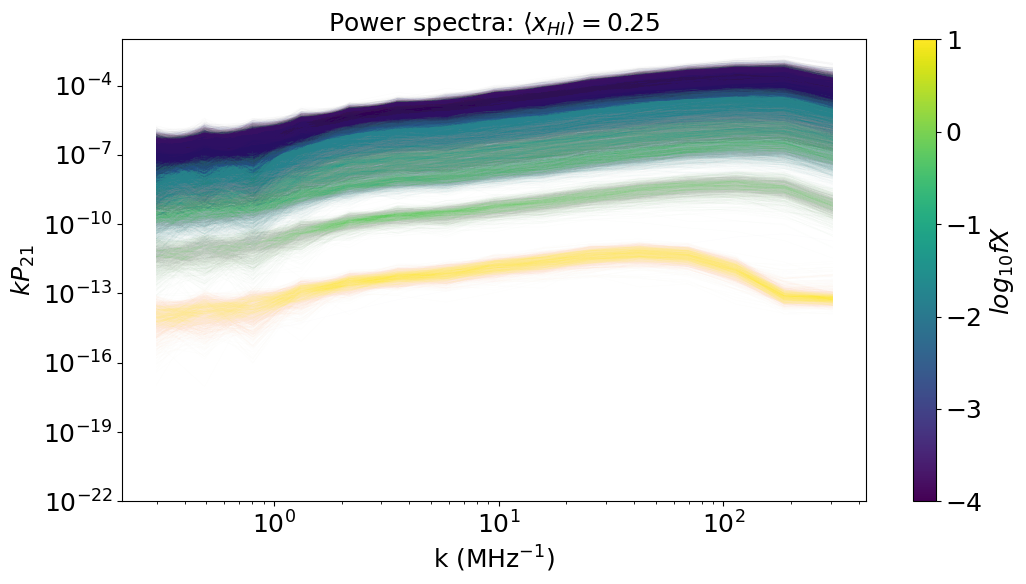

<Figure size 1200x600 with 0 Axes>

In [98]:
ks025_binb1, ps025_binb1 = logbin_power_spectrum_by_k(ks025b1, ps025b1,16)
base.plot_power_spectra(ps025_binb1, ks025_binb1, params025b1, psn=psn1000, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25$")



Combined data shape: (19, 2762)
Combined parameters shape: (19, 2)
min-max range: -4.0-1.0


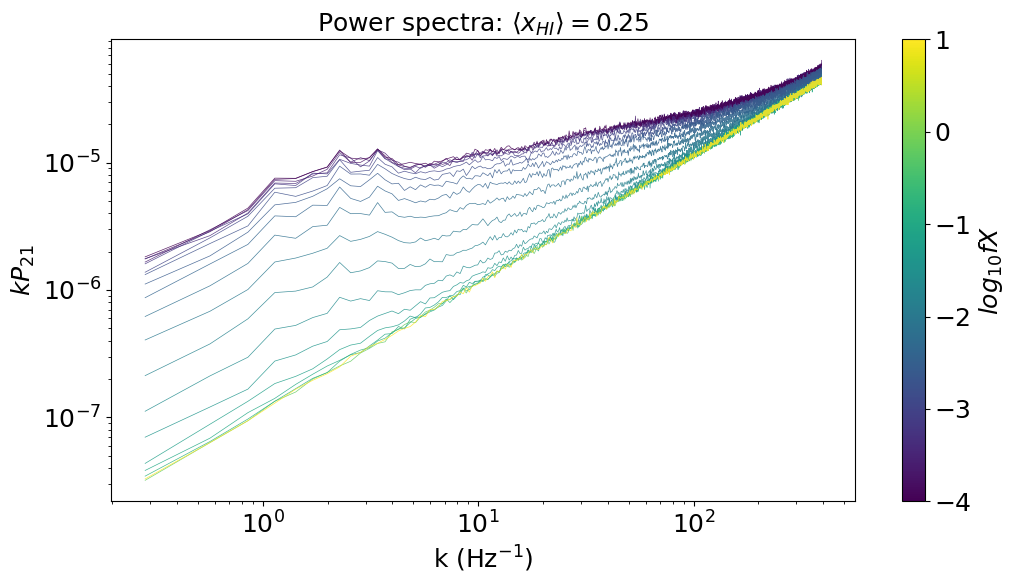

TypeError: logbin_power_spectrum_by_k() takes 2 positional arguments but 3 were given

<Figure size 1200x600 with 0 Axes>

In [17]:
import glob
files025sn=glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX*_xHI0.25*uGMRT_8kHz_t500h*.dat")
params025sn, freq025sn, los025sn, ps025sn, ks025sn = load_dataset(files025sn, psbatchsize=1000, ps_bins=None, limitsamplesize=None)
base.plot_power_spectra(ps025sn, ks025sn, params025sn, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25$")
ks025sn_bin, ps025sn_bin = logbin_power_spectrum_by_k(ks025sn, ps025sn,18)
base.plot_power_spectra(ps025sn_bin, ks025sn_bin, params025sn, psn=psn1000, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle=0.25 Noisy$")



In [1]:
files02sn=glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI*_uGMRT_8kHz_t500h*.dat")
params02sn, freq02sn, los02sn, ps02sn, ks02sn = load_dataset(files02sn, psbatchsize=1000, ps_bins=None, limitsamplesize=None)
base.plot_power_spectra(ps02sn, ks02sn, params02sn, colorind=0, showplots=True, saveplots=False, label=r'$log_{10}fX=-2 Noisy$')

ks02sn_bin, ps02sn_bin = logbin_power_spectrum_by_k(ks02sn, ps02sn,18)
base.plot_power_spectra(ps02sn_bin, ks02sn_bin, params02sn, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=-2.00 Noisy$")



NameError: name 'glob' is not defined

Number of pixels (original): 2762
Number of pixels (smoothed): 2761
Bandwidth = 22.08MHz
Error processing ../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.30_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
operands could not be broadcast together with shapes (11045,) (11046,) 
Number of pixels (original): 2762
Number of pixels (smoothed): 2761
Bandwidth = 22.08MHz
Error processing ../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.25_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
operands could not be broadcast together with shapes (11045,) (11046,) 
Number of pixels (original): 2762
Number of pixels (smoothed): 2761
Bandwidth = 22.08MHz
Error processing ../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.20_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
operands could not be broadcast together with shapes (11045,) (11046,) 
Number of pixels (original): 2762
Number of pixels (smoothed): 2761
Bandwidth = 22.08MHz
Error pr

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [14]:
stats01sn = calculate_stats_torch(los01sn, params01sn, [268])
base.plotstats(stats01sn)

NameError: name 'los01sn' is not defined

In [11]:
filesn=glob.glob("../data/21cmFAST_los/F21_noisy/F21_noiseonly_21cmFAST_200Mpc_z6.0*_uGMRT_8kHz_t500h*.dat")
paramsn, freqn, losn, psn, ksn = load_dataset(filesn, psbatchsize=1000, ps_bins=None, limitsamplesize=None)
#base.plot_single_power_spectrum(psn, ksn, paramsn, colorind=0, showplots=True, saveplots=False, label=r'Pure Noise')

ksn_bin, psn_bin = logbin_power_spectrum_by_k(ksn, psn,18)
#base.plot_single_power_spectrum(psn_bin, ksn_bin, paramsn, colorind=1, showplots=True, saveplots=False, label=r"Pure Noise Binned")

Number of pixels (original): 2762
Number of pixels (smoothed): 2761
Bandwidth = 22.08MHz

Combined data shape: (1, 22089)
Combined parameters shape: (1, 2)


min-max range: -999--999


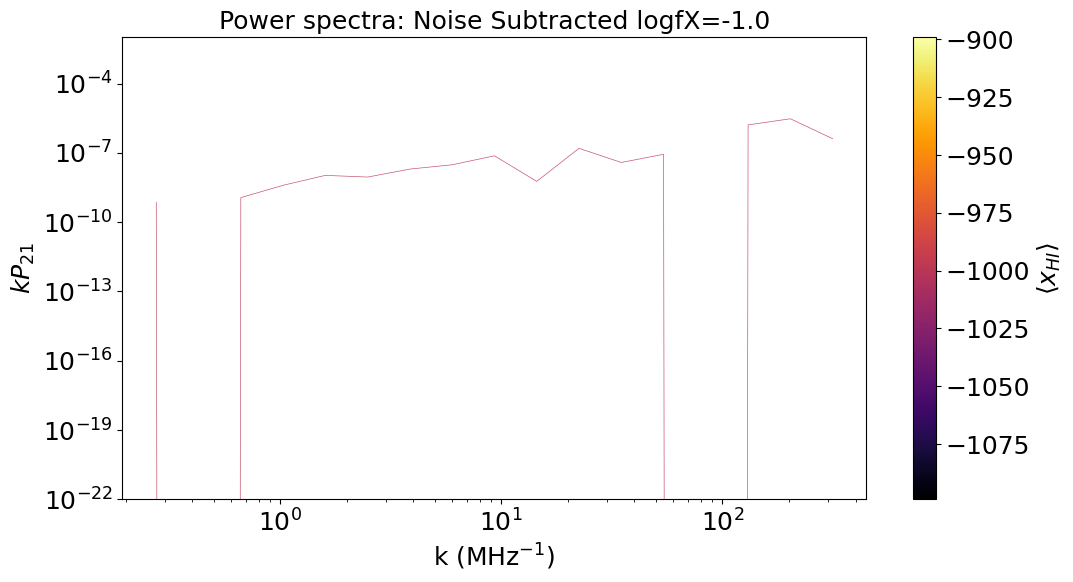

<Figure size 1200x600 with 0 Axes>

In [125]:
ps01_sub_bin = ps01sn_bin - psn_bin
base.plot_power_spectra(ps01_sub_bin, ks01sn_bin, paramsn, colorind=0, showplots=True, saveplots=False, label=r"Noise Subtracted logfX=-1.0")


min-max range: -4.0-1.0


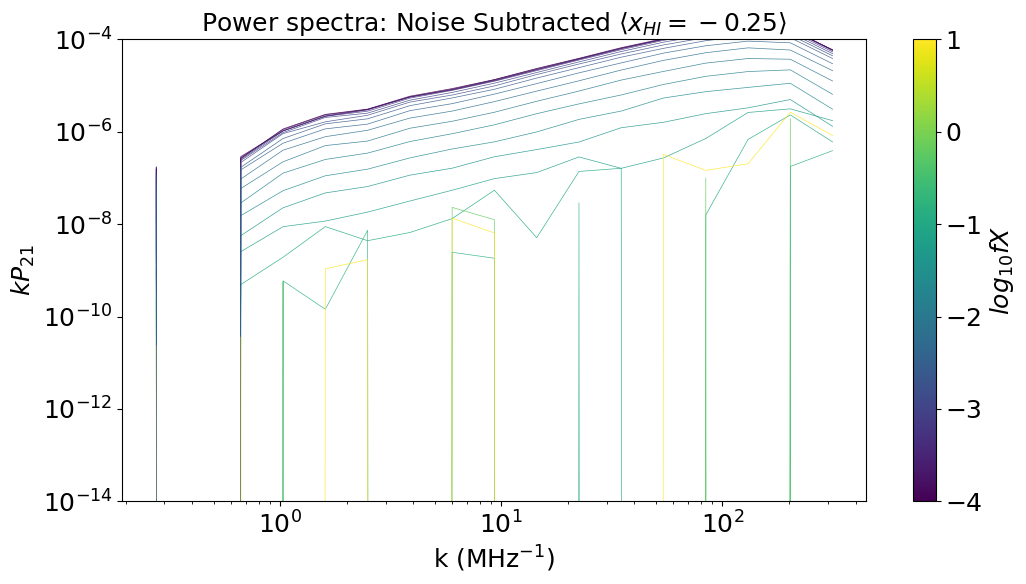

<Figure size 1200x600 with 0 Axes>

In [128]:
ps025_sub_bin = ps025sn_bin - psn_bin


Combined data shape: (21000, 2762)
Combined parameters shape: (21000, 2)
min-max range: 0.0034089593682438135-0.9779895544052124


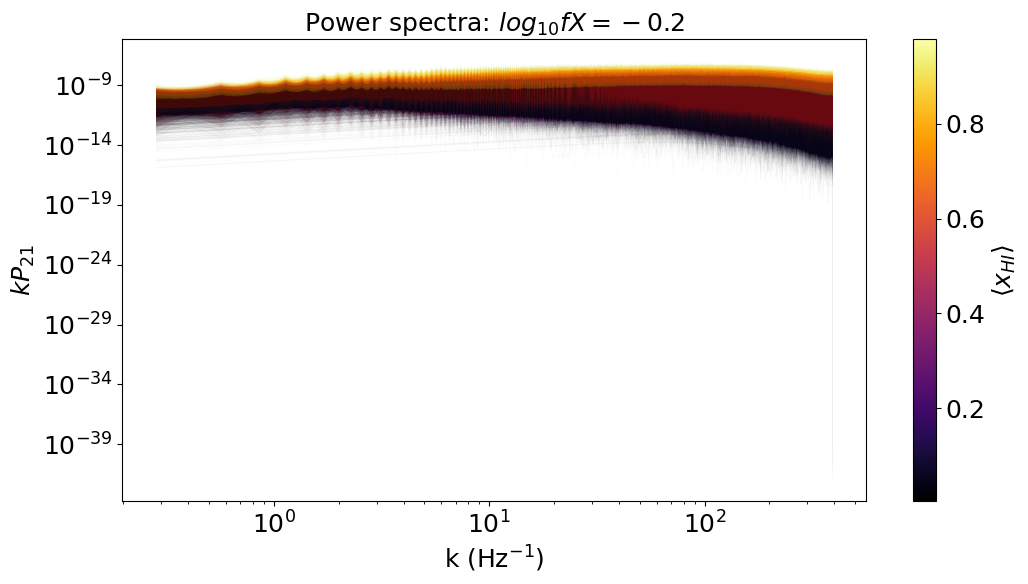

<Figure size 1200x600 with 0 Axes>

In [26]:
files02so=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-0.20_xHI*8kHz*.dat")
params02sob1, freq02sob1, los02sob1, ps02sob1, ks02sob1 = load_dataset(files02so, psbatchsize=1, ps_bins=None)
base.plot_power_spectra(ps02sob1, ks02sob1, params02sob1, colorind=0, showplots=True, saveplots=False, label=r'$log_{10}fX=-0.2$')

logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 4.34189959e-10 1.44004685e-10 1.29875895e-09
 1.52551901e-10]..[6.08525462e-10 1.02125675e-09 7.12571349e-10 4.19116570e-10
 1.50315468e-10]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 4.34189959e-10 1.44004685e-10
 7.25655428e-10]..[1.29259567e-08 8.93569136e-09 7.41799137e-09 2.27807873e-09
 0.00000000e+00]
min-max range: 0.0034089593682438135-0.97798

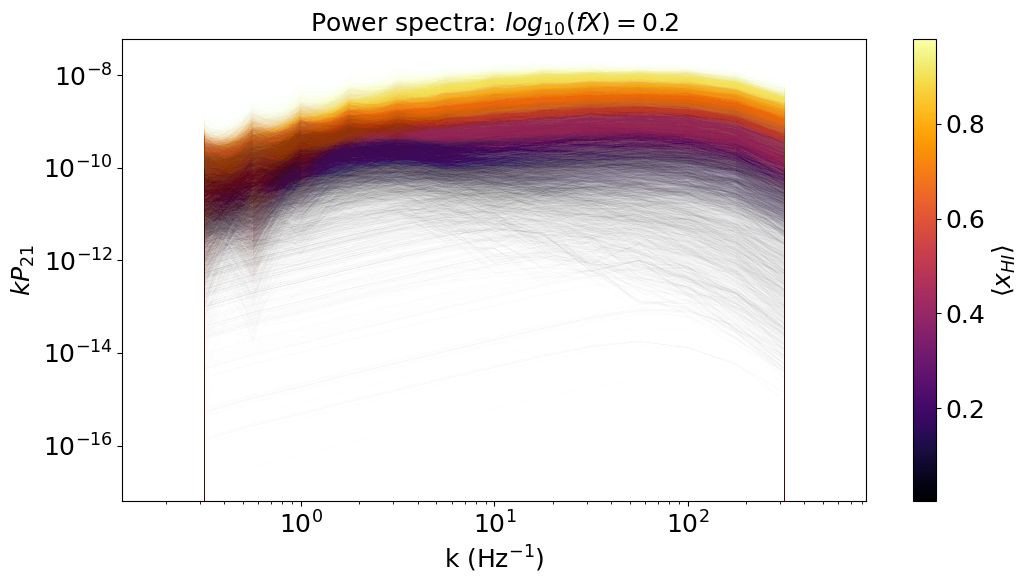

<Figure size 1200x600 with 0 Axes>

In [27]:
ks02so_binb1, ps02so_binb1 = logbin_power_spectrum_by_k(ks02sob1, ps02sob1)
base.plot_power_spectra(ps02so_binb1, ks02so_binb1, params02sob1, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=0.2$")



Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)
min-max range: 0.0034089593682438135-0.9779895544052124


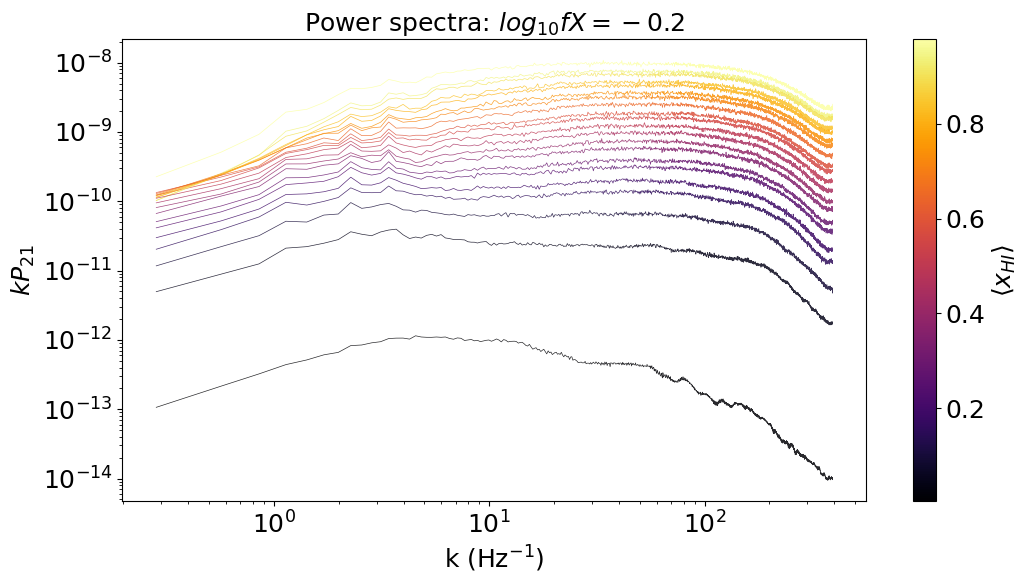

TypeError: logbin_power_spectrum_by_k() takes 2 positional arguments but 3 were given

<Figure size 1200x600 with 0 Axes>

In [24]:
files02so=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-0.20_xHI*8kHz*.dat")
params02sob1000, freq02sob1000, los02sob1000, ps02sob1000, ks02sob1000 = load_dataset(files02so, psbatchsize=1000, ps_bins=None)
base.plot_power_spectra(ps02sob1000, ks02sob1000, params02sob1000, colorind=0, showplots=True, saveplots=False, label=r'$log_{10}fX=-0.2$')


logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 2.25799774e-10 5.11286259e-10 9.25634901e-10
 1.93596111e-09]..[2.26398238e-09 2.31448525e-09 2.29879725e-09 2.32462755e-09
 2.51231038e-09]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 2.25799774e-10 5.11286259e-10
 1.43079801e-09]..[9.58024114e-09 8.82325748e-09 6.46876486e-09 3.04843101e-09
 0.00000000e+00]
min-max range: 0.0034089593682438135-0.97798

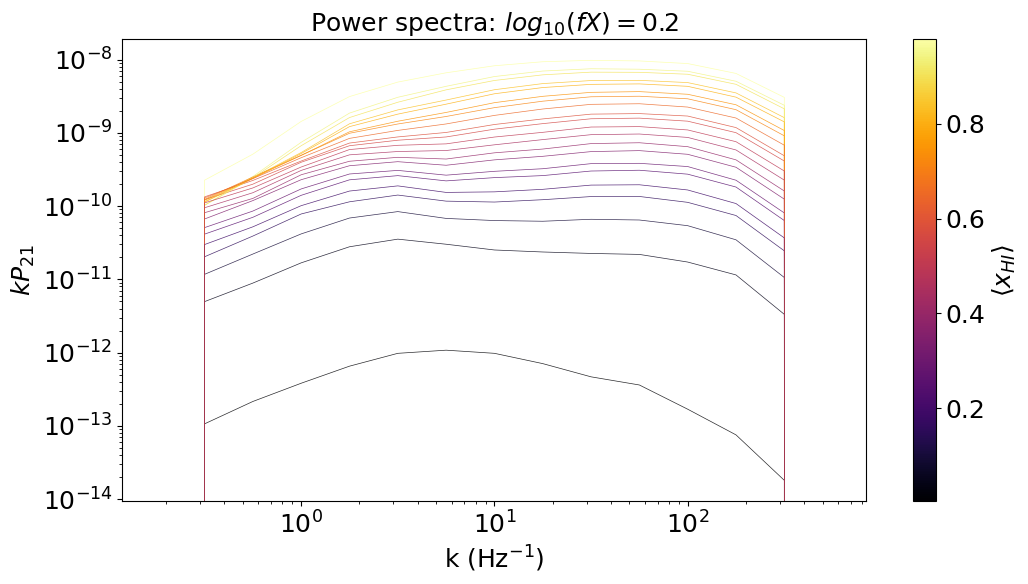

<Figure size 1200x600 with 0 Axes>

In [28]:
ks02so_binb1000, ps02so_binb1000 = logbin_power_spectrum_by_k(ks02sob1000, ps02sob1000)
base.plot_power_spectra(ps02so_binb1000, ks02so_binb1000, params02sob1000, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}(fX)=0.2$")


In [29]:
files02so=glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI*.dat")
params02so, freq02so, los02so, ps02so, ks02so = load_dataset(files02so, psbatchsize=1000, ps_bins=None, limitsamplesize=None)
ks02so_bin, ps02so_bin = logbin_power_spectrum_by_k(ks02so, ps02so)



Combined data shape: (21, 2762)
Combined parameters shape: (21, 2)
logbin_power_spectrum_by_k: original ks: [0.00000000e+00 2.84444178e-07 5.68888357e-07 8.53332535e-07
 1.13777671e-06] .. [0.00039168 0.00039196 0.00039225 0.00039253 0.00039282]
original ps: [0.00000000e+00 1.17075240e-07 2.03407119e-07 3.18777808e-07
 5.19892393e-07]..[5.41655716e-07 5.05531666e-07 4.85401730e-07 5.11343979e-07
 5.29710657e-07]
[1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04]
logbin_power_spectrum_by_k: final ks: [1.00000000e-07 1.77827941e-07 3.16227766e-07 5.62341325e-07
 1.00000000e-06]..[5.62341325e-05 1.00000000e-04 1.77827941e-04 3.16227766e-04
 5.62341325e-04]
final ps: [0.00000000e+00 0.00000000e+00 1.17075240e-07 2.03407119e-07
 4.19335100e-07]..[7.25039515e-07 6.78932967e-07 6.13706676e-07 5.153608

In [30]:
ps02_sub_bin = ps02sn_bin - psn_bin
base.plot_power_spectra(ps02_sub_bin, ks02sn_bin, params02sn, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Noise Subtracted")


NameError: name 'ps02sn_bin' is not defined

In [2]:
base.plot_power_spectra(ps10so_bin, ks10so_bin, params10so, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-1.00 Signal Only")
base.plot_power_spectra(ps01sn_bin, ks01sn_bin, params01sn, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-1.00 Noisy")
base.plot_power_spectra(ps01_sub_bin, ks01sn_bin, paramsn, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-1.0 Noise Subtracted")
base.plot_power_spectra(ps025sn_bin, ks025sn_bin, params025sn, colorind=1, showplots=True, saveplots=False, label=r"$\langle x_{HI}\rangle$=0.25 Noisy")
base.plot_power_spectra(ps025_sub_bin, ks025sn_bin, params025sn, colorind=1, showplots=True, saveplots=False, label=r"Noise Subtracted $\langle x_{HI}=-0.25\rangle$")
base.plot_power_spectra(ps02so_bin, ks02so_bin, params02so, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Signal Only")
base.plot_power_spectra(ps02sn_bin, ks02sn_bin, params02sn, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Noisy")
base.plot_power_spectra(ps02_sub_bin, ks02sn_bin, params02so, colorind=0, showplots=True, saveplots=False, label=r"$log_{10}$(fX)=-2.00 Noise Subtracted")


NameError: name 'base' is not defined

In [134]:
print(ks10so_bin[0])
print(ks01sn_bin[0])
print(ks025sn_bin[0])
print(ks02so_bin[0])
print(ks02sn_bin[0])


[1.77298551e-07 2.75338411e-07 4.27590864e-07 6.64033567e-07
 1.03122076e-06 1.60144956e-06 2.48699482e-06 3.86221544e-06
 5.99788469e-06 9.31450387e-06 1.44650968e-05 2.24637863e-05
 3.48854697e-05 5.41759069e-05 8.41332772e-05 1.30656019e-04
 2.02904200e-04 3.15103083e-04]
[1.77298551e-07 2.75338411e-07 4.27590864e-07 6.64033567e-07
 1.03122076e-06 1.60144956e-06 2.48699482e-06 3.86221544e-06
 5.99788469e-06 9.31450387e-06 1.44650968e-05 2.24637863e-05
 3.48854697e-05 5.41759069e-05 8.41332772e-05 1.30656019e-04
 2.02904200e-04 3.15103083e-04]
[1.77298551e-07 2.75338411e-07 4.27590864e-07 6.64033567e-07
 1.03122076e-06 1.60144956e-06 2.48699482e-06 3.86221544e-06
 5.99788469e-06 9.31450387e-06 1.44650968e-05 2.24637863e-05
 3.48854697e-05 5.41759069e-05 8.41332772e-05 1.30656019e-04
 2.02904200e-04 3.15103083e-04]
[1.77298551e-07 2.75338411e-07 4.27590864e-07 6.64033567e-07
 1.03122076e-06 1.60144956e-06 2.48699482e-06 3.86221544e-06
 5.99788469e-06 9.31450387e-06 1.44650968e-05 2.24

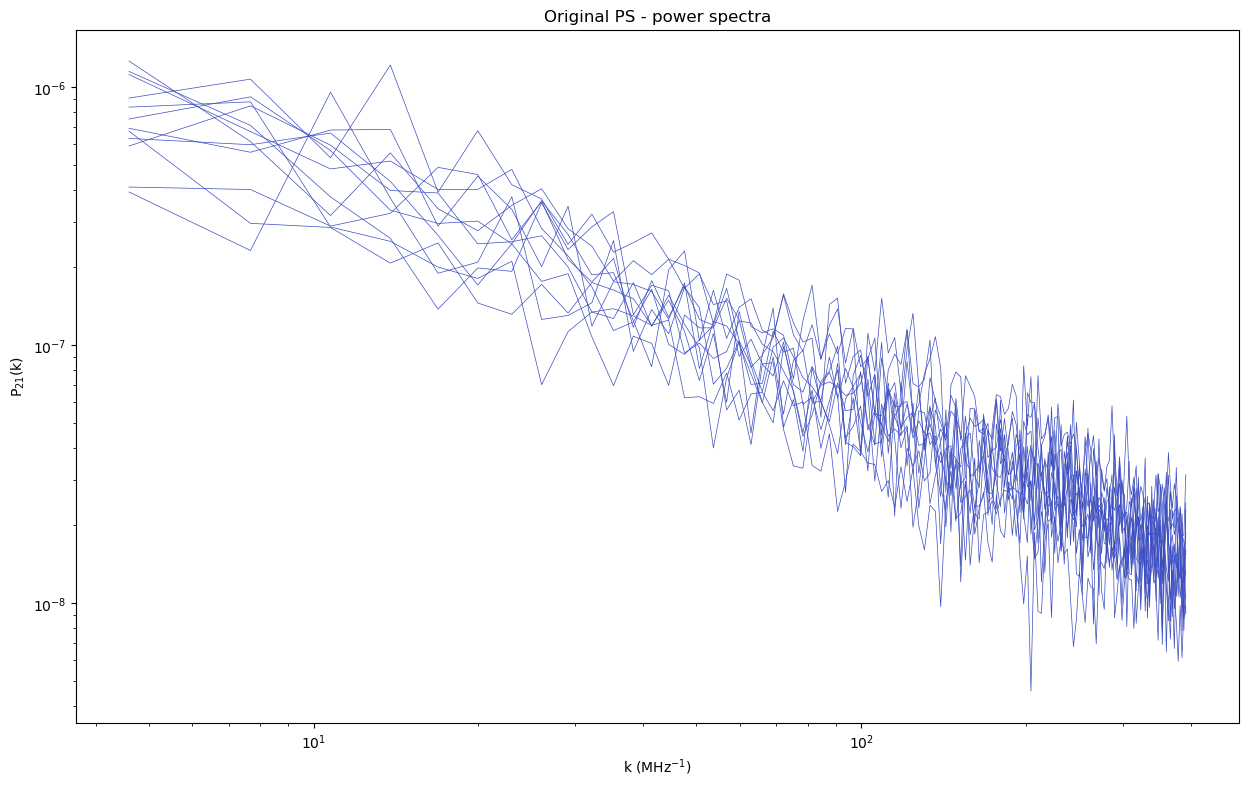

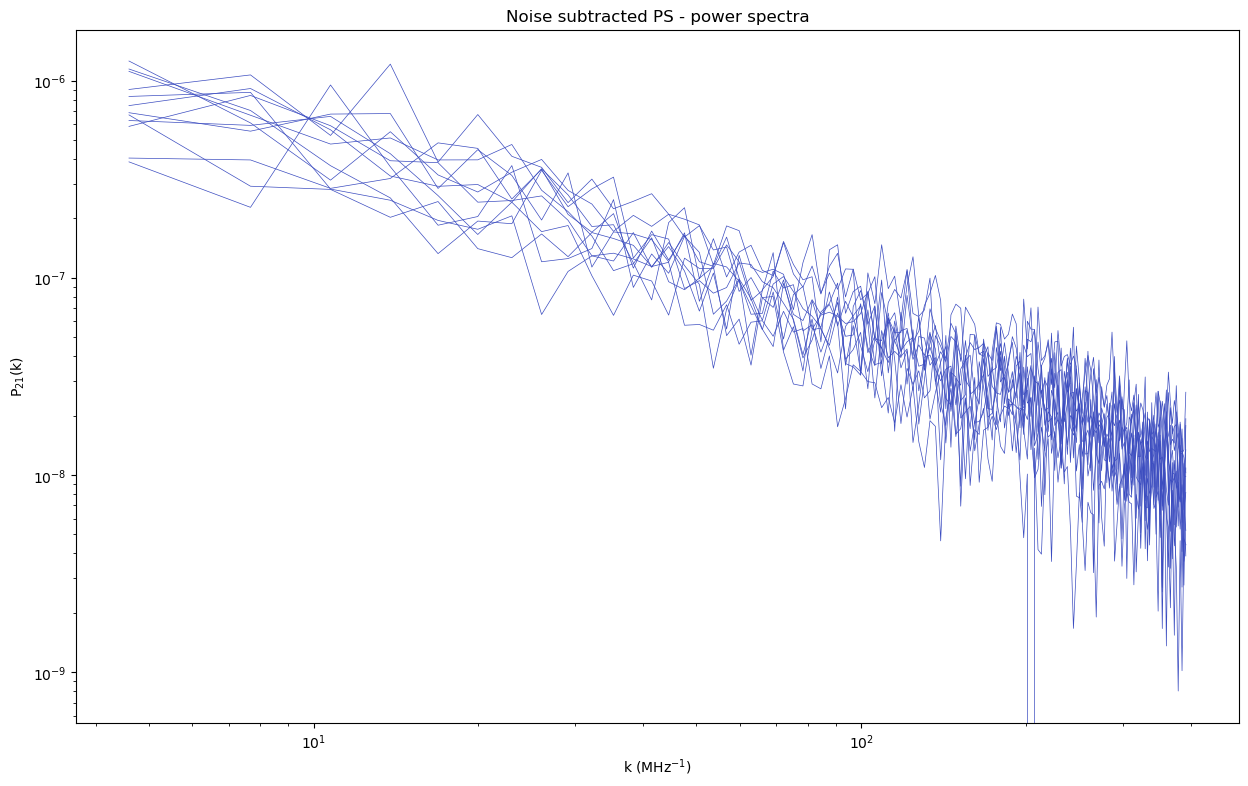

<Figure size 1500x900 with 0 Axes>

In [13]:
ps_sub = ps - psn
ps2_sub = ps2 - psn
ps1_sub = ps1 - psn

X_ps = np.vstack((ps, ps2, ps1))
X_ps_sub = np.vstack((ps_sub, ps2_sub, ps1_sub))
ks_np = np.vstack((ks, ks2, ks1))
base.plot_power_spectra(X_ps, np.vstack((ks, ks2, ks1)), np.vstack((params,params2, params1)), showplots=True, saveplots=False, label="Original PS")
base.plot_power_spectra(X_ps_sub, ks_np, np.vstack((params,params2, params1)), showplots=True, saveplots=False, label="Noise subtracted PS")


In [31]:

# main
#(params, freq, los, ps, ks) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.40_xHI0.25_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1)
(params, freq, los, ps, ks) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-4.00_xHI0.94_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1)
(params, freqp, losp, psp, ksp) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-4.00_xHI0.94_8kHz.dat"], psbatchsize=1)
(params2, freq2, los2, ps2, ks2) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-4.00_xHI0.25_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1)
(params2p, freq2p, los2p, ps2p, ks2p) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-4.00_xHI0.25_8kHz.dat"], psbatchsize=1)
(params1, freq1, los1, ps1, ks1) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.29_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1)
(params1p, freq1p, los1p, ps1p, ks1p) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.29_8kHz.dat"], psbatchsize=1)
(paramsn, freqn, losn, psn, ksn) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noiseonly_21cmFAST_200Mpc_z6.0_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1000)


Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)

Combined data shape: (1, 2762)
Combined parameters shape: (1, 2)


In [13]:
from scipy.stats import binned_statistic

def  bin_ps_data(X, ks, ps_bins_to_make, ps_bins_to_use):
    if X.shape[1] <  ps_bins_to_make:
        ps_bins_to_make = X.shape[1]

    num_bins = ps_bins_to_make*ps_bins_to_use//100

    if ps_bins_to_make < X.shape[1]:
        X_binned = []
        ks_binned = []
        for x, k in zip(X, ks):
            ps, k_ind, _ = binned_statistic(k, x, statistic='mean', bins=num_bins)
            k_bins = 0.5*(k_ind[1:]+k_ind[:-1])
            X_binned.append(ps)
            ks_binned.append(k_bins)
        X_binned = np.array(X_binned)
        ks_binned = np.array(X_binned)
    else:
        X_binned = X
        ks_binned = ks
    return X_binned[:,:ps_bins_to_use], ks_binned[:,:ps_bins_to_use]



In [9]:

X_ps_bin, ks_bin = bin_ps_data(X_ps, ks_np, 100, 100)
psn_bin, ks_bin = bin_ps_data(np.array([psn]), np.array([ksn]), 100, 100)

X_ps_bin_sub = X_ps_bin - psn_bin

base.plot_power_spectra(X_ps_bin, ks_bin, np.vstack((params,params2, params1)), showplots=True, saveplots=False, label="Original PS")
base.plot_power_spectra(X_ps_bin_sub, ks_bin, np.vstack((ks, ks2, ks1)), np.vstack((params,params2, params1)), showplots=True, saveplots=False, label="Noise subtracted PS")


KeyboardInterrupt: 

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_12538/778838834.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'Skewness': [stats.skew(p) for p in pieces],


Mean, stdev. skew2 of Skewness pure los_0.94_-4.00 33 = nan, nan, nan
Mean, stdev. skew2 of Skewness los_0.94_-4.00 33 = -1.2312545271396542, 1.2245350613895203, -0.3860270464238018
Mean, stdev. skew2 of Skewness los_0.25_-4.00 33 = -0.24802533226009074, 0.7745078616254498, -1.8355063850922453
Mean, stdev. skew2 of Skewness los1_0.29_-0.2 33 = 0.04833093984439935, 0.3933037469033851, 0.21797735290194784
Mean, stdev. skew2 of Skewness noise 33 = 0.018125908564268135, 0.4022505961080116, 0.4714664056765084


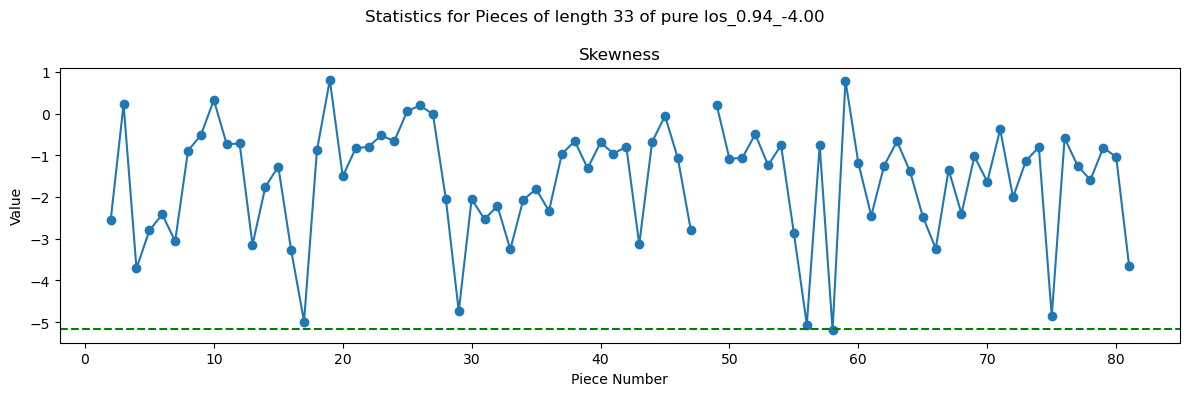

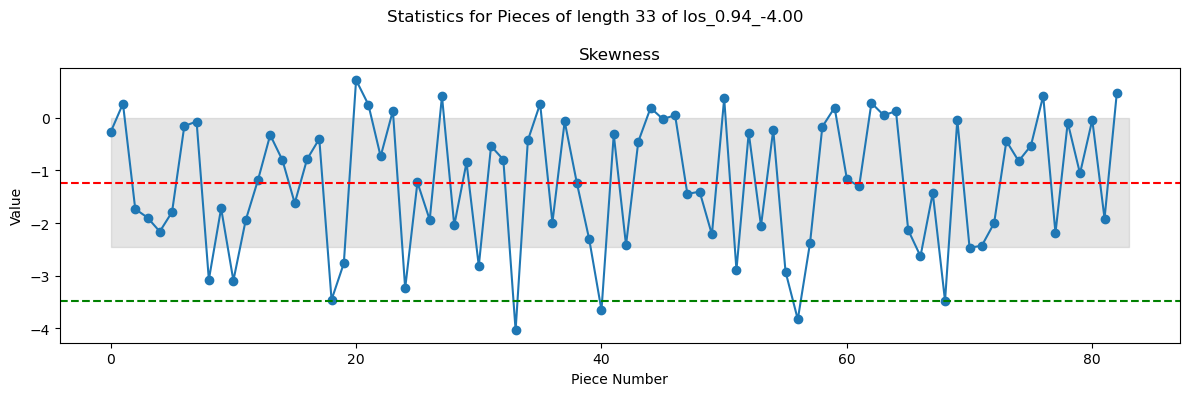

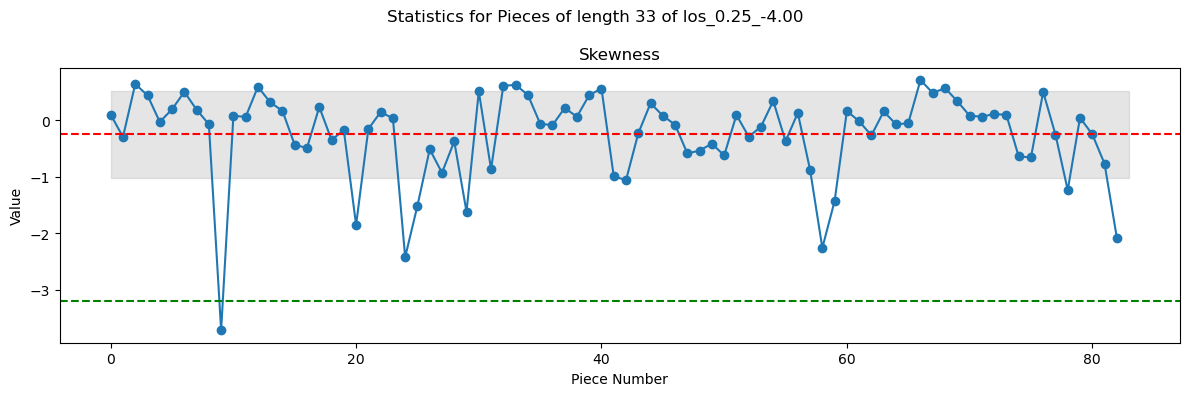

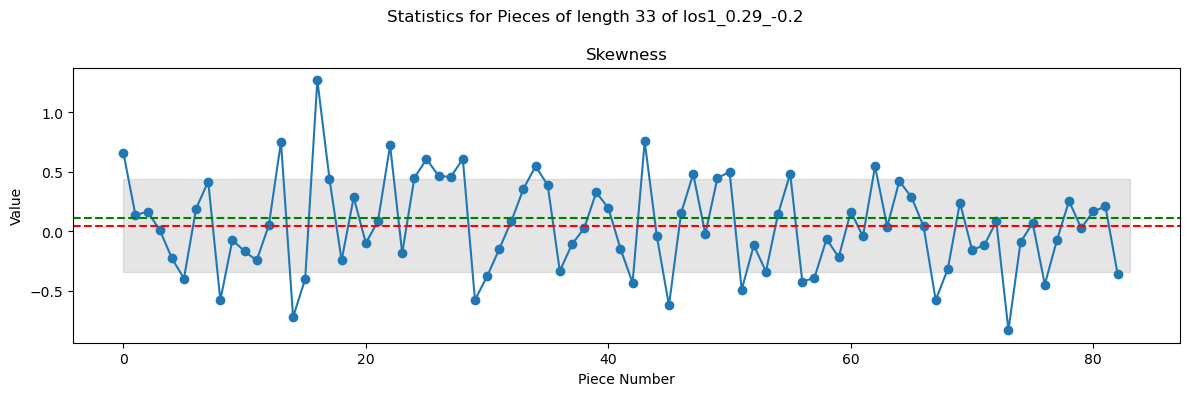

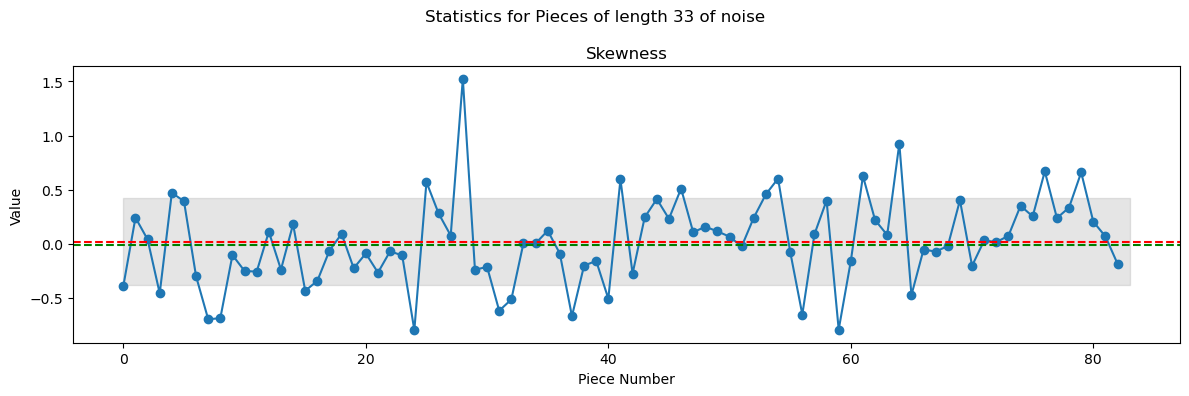

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint

# Take 10 random samples from los
#np.random.seed(42)  # For reproducibility

def show_stats(los, sample_num=0, nsamples=10, label="", piece_length=11):
    sample_indices = np.random.choice(los.shape[0], nsamples, replace=False)
    samples = los[sample_indices]

    # Calculate statistics for each sample
    stats_dict = {
        'Sample': range(nsamples),
        'Mean': [np.mean(s) for s in samples],
        'Std Dev': [np.std(s) for s in samples],
        'Skewness': [stats.skew(s) for s in samples],
        'Kurtosis': [stats.kurtosis(s) for s in samples]
    }

    """
    # Create and display table
    stats_df = pd.DataFrame(stats_dict)
    print(f"Statistics for {nsamples} random samples from {label}:")
    print(stats_df.to_string(index=False))
    """

    # Split first sample into pieces of length 5 and analyze
    sample = samples[sample_num]
    total_skew = stats.skew(sample)
    pieces = np.array_split(sample, len(sample)//piece_length)

    # Calculate statistics for each piece
    piece_stats = {
        #'Mean': [np.mean(p) for p in pieces],
        #'Std Dev': [np.std(p) for p in pieces],
        'Skewness': [stats.skew(p) for p in pieces],
        #'Kurtosis': [stats.kurtosis(p) for p in pieces]
    }
    

    """
    # Calculate quintiles
    quintiles = np.percentile(piece_stats['Skewness'], [20, 40, 60, 80])
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(piece_stats['Skewness'], bins=30, edgecolor='black')
    
    # Add vertical lines for quintiles
    for i, q in enumerate(quintiles):
        plt.axvline(x=q, color='r', linestyle='--', alpha=0.5, 
                   label=f'Q{i+1}: {q:.2f}')
    
    plt.title(f'Histogram of Skewness Values for {label}')
    plt.xlabel('Skewness')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    """
    # Plot statistics for pieces
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    fig.suptitle(f'Statistics for Pieces of length {piece_length} of {label}')

    for (stat, values) in piece_stats.items():
        ax.plot(values, marker='o')
        ax.set_title(stat)
        ax.set_xlabel('Piece Number')
        ax.set_ylabel('Value')
        # Calculate mean and standard deviation
        mean_val = np.mean(values)
        std_val = np.std(values)
        skewness2 = stats.skew(values)
        print(f'Mean, stdev. skew2 of {stat} {label} {piece_length} = {mean_val}, {std_val}, {skewness2}')
        # Add mean line
        plt.axhline(y=mean_val, color='red', linestyle='--', label=f'Mean ({mean_val:.2f})')
        plt.axhline(y=total_skew, color='green', linestyle='--', label=f'Total ({mean_val:.2f})')
    
        # Add standard deviation shading
        plt.fill_between( [0, len(values)],
                    mean_val - std_val,
                    mean_val + std_val,
                    color='gray',
                    alpha=0.2,
                    label=f'±1 Std Dev ({std_val:.2f})')
    
    plt.tight_layout()
    plt.legend
    #plt.show()
    
for piece_length in [33]: # [3, 5, 9, 17, 33, 65]:
    show_stats(losp, sample_num=randint(0, 10), nsamples=10, label="pure los_0.94_-4.00", piece_length=piece_length)
    show_stats(los, sample_num=randint(0, 10), nsamples=10, label="los_0.94_-4.00", piece_length=piece_length)
    show_stats(los2, sample_num=randint(0, 10), nsamples=10,label="los_0.25_-4.00", piece_length=piece_length)
    show_stats(los1, sample_num=randint(0, 10), nsamples=10,label="los1_0.29_-0.2", piece_length=piece_length)
    show_stats(losn, sample_num=0, nsamples=1, label="noise", piece_length=piece_length)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(f"{los.shape}")
agg_los =  np.mean(los, axis=0)
print(f"{agg_los.shape}")
base.plot_single_los(agg_los, freq[0], showplots=True)

agg_los1 =  np.mean(los1, axis=0)
base.plot_single_los(agg_los1, freq1[0], showplots=True)

agg_losn =  np.mean(losn, axis=0)
base.plot_single_los(agg_losn, freqn[0], showplots=True)


float64 float64 (1000, 128) (1000, 128)
float64 float64 (1000, 128) (1000, 128)


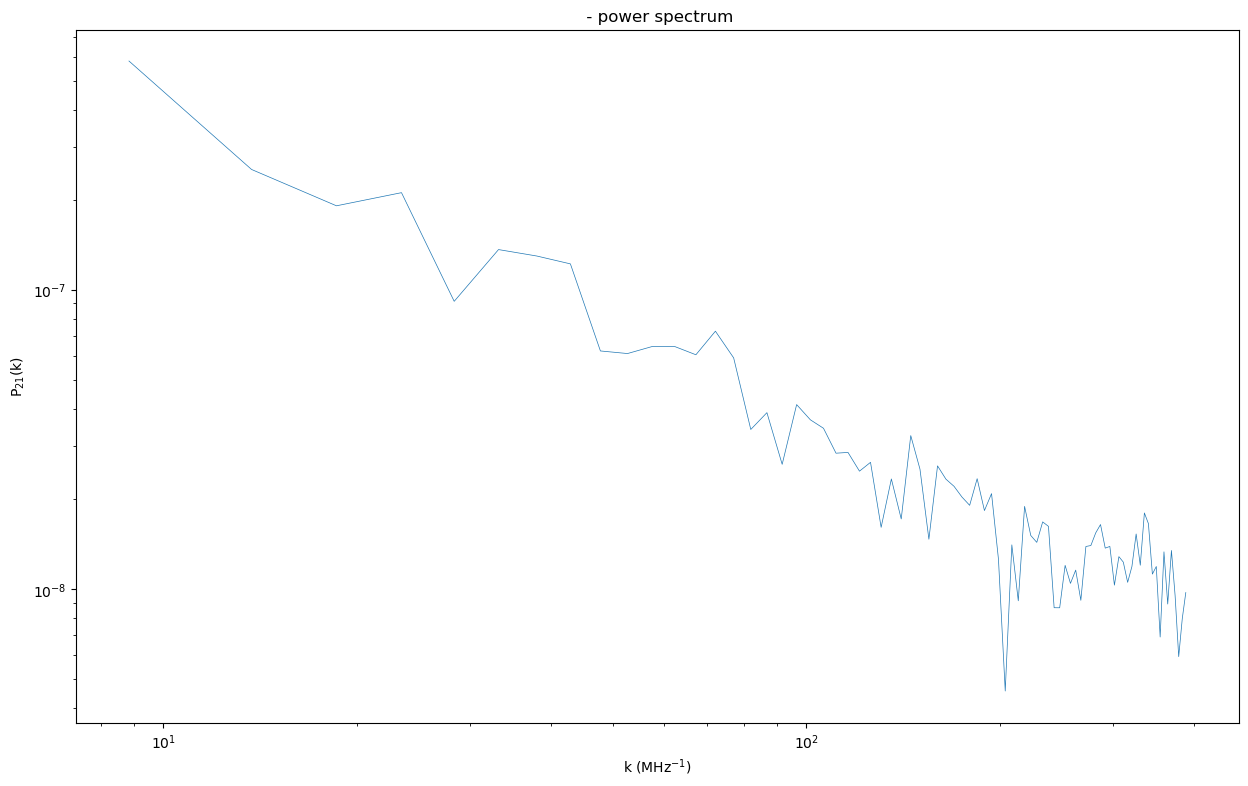

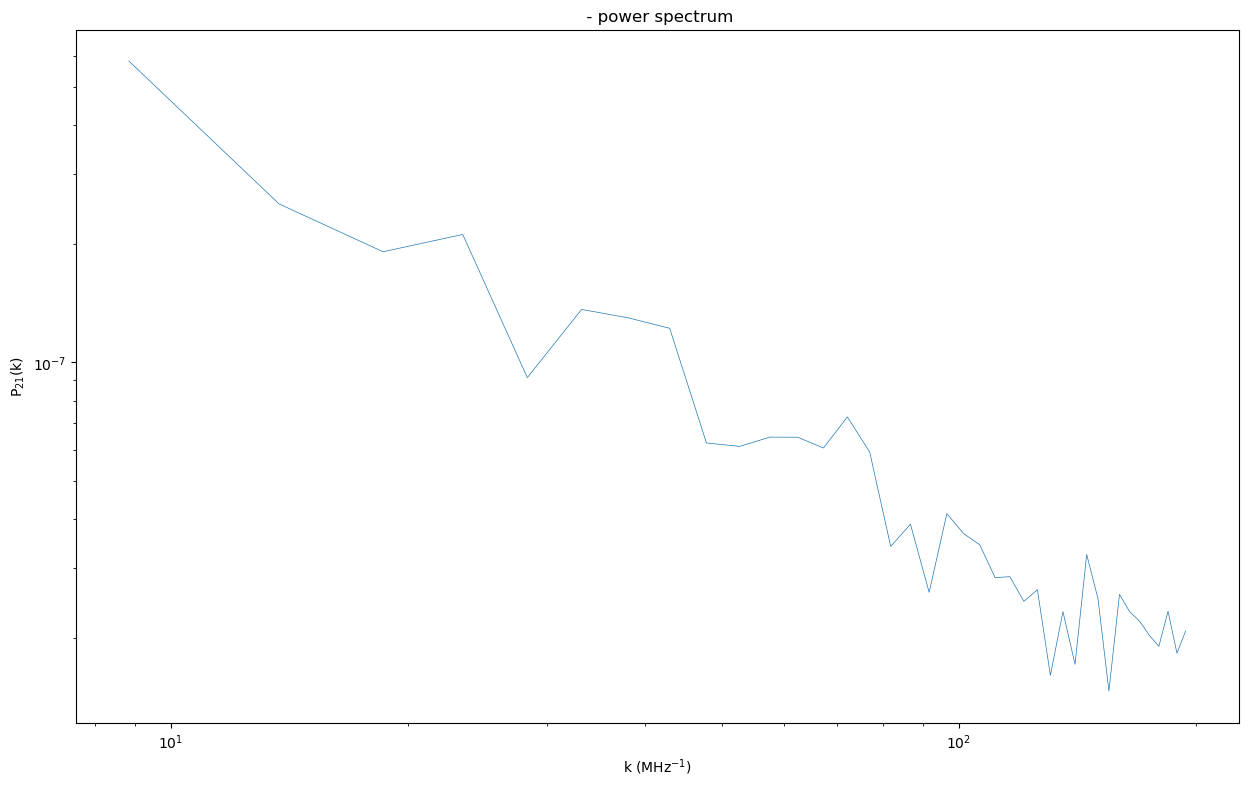

ValueError: too many values to unpack (expected 2)

<Figure size 1500x900 with 0 Axes>

In [6]:
from scipy.stats import binned_statistic

print(f"{ks.dtype} {ps.dtype} {ks.shape} {ps.shape}")
ks = np.array(ks)
ps = np.array(ps)
print(f"{ks.dtype} {ps.dtype} {ks.shape} {ps.shape}")
ps, bin_edges, _ = binned_statistic(np.abs(ks[0]), ps[0], statistic='mean', bins=80)
ks = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Bin centers
base.plot_single_power_spectrum(ps, ks, showplots=True)
base.plot_single_power_spectrum(ps[:40], ks[:40], showplots=True)

ps1, bin_edges, _ = binned_statistic(np.abs(ks1), ps1, statistic='median', bins=80)
ks1 = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Bin centers
base.plot_single_power_spectrum(ps1[:40], ks1[:40], showplots=True)

psn, bin_edges, _ = binned_statistic(np.abs(ksn), psn, statistic='median', bins=80)
ksn = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Bin centers
base.plot_single_power_spectrum(psn[:40], ksn[:40], showplots=True)
"""
import PS1D
ks, ps = PS1D.get_P(los[0], scaled=True)
binned_ps = binned_power_spectrum(ks, ps)
base.plot_power_spectra(all_ps[:4], all_ks[:4], all_params[:4], showplots=True, saveplots = False)
"""

(10, 40)
(1, 40)
(4, 40)


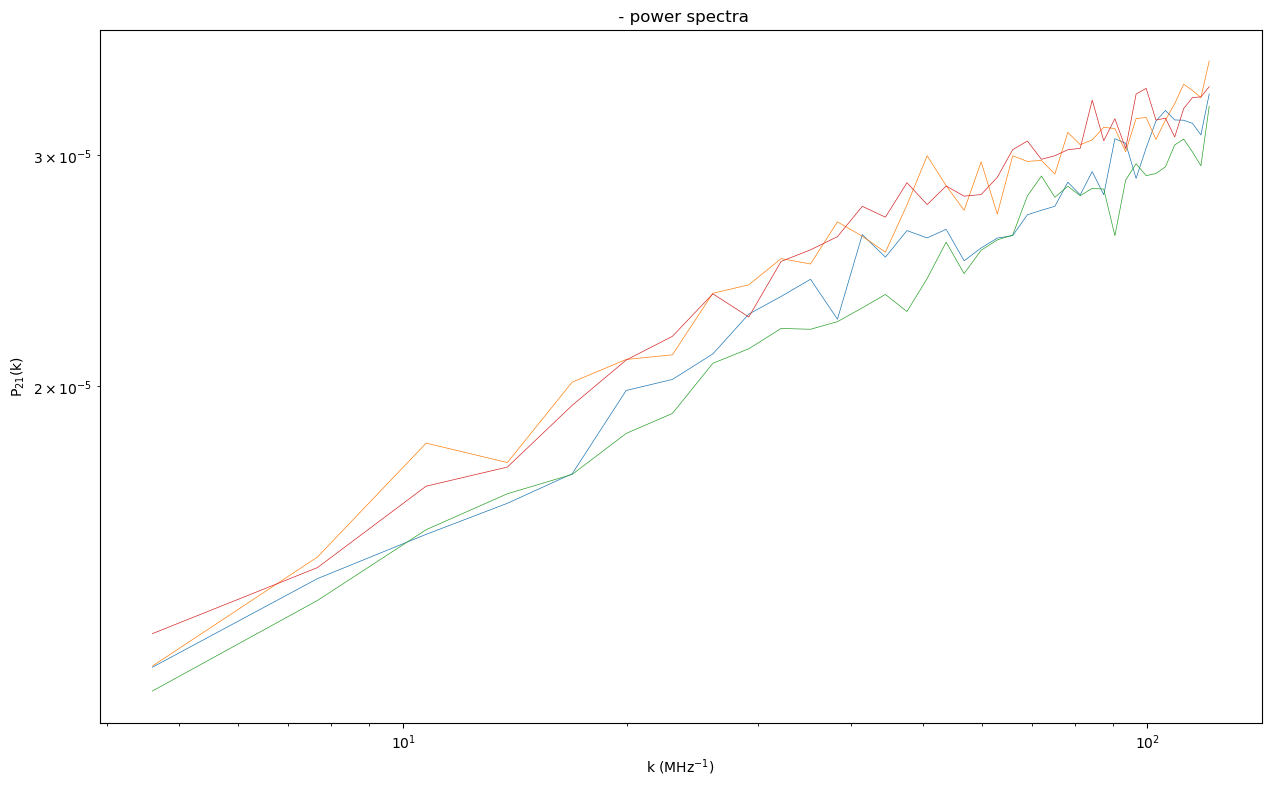

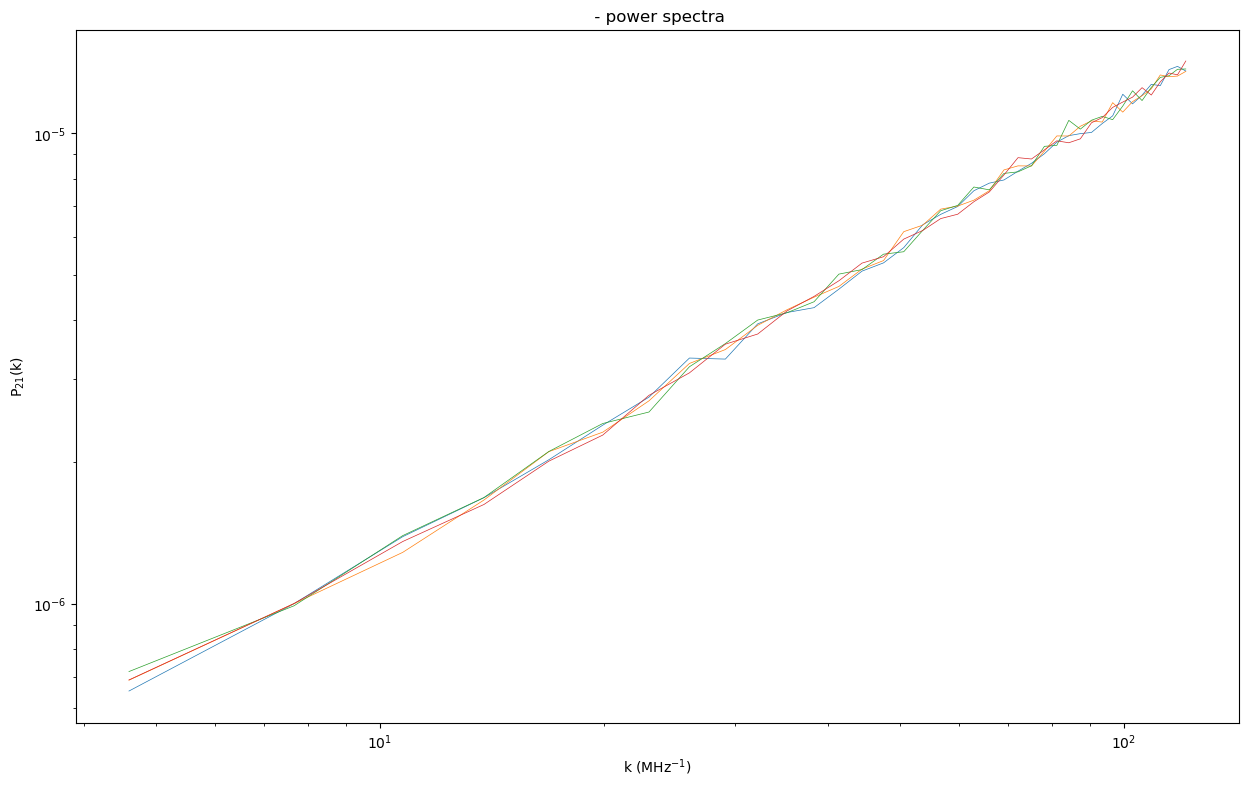

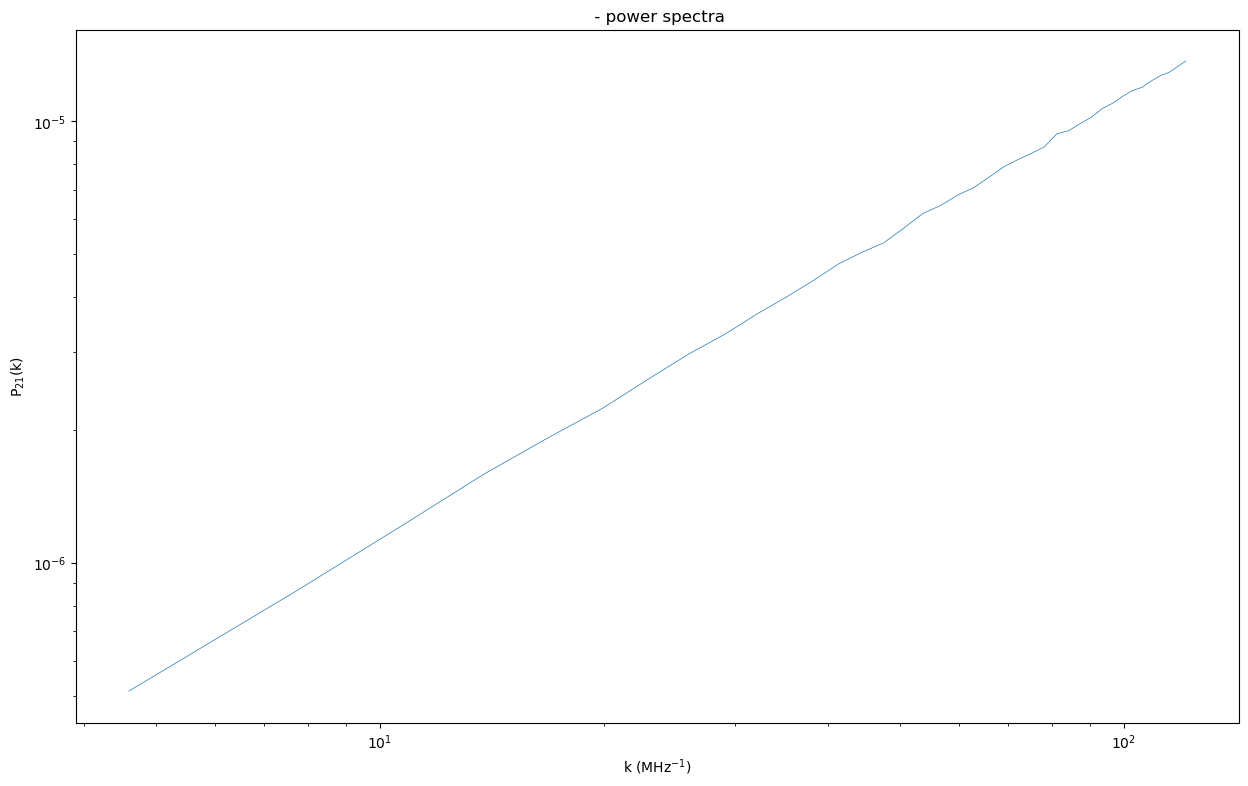

<Figure size 1500x900 with 0 Axes>

In [2]:
import numpy as np
bins=40
ps=ps[:,:bins]
ks=ks[:,:bins]
ps1=ps1[:,:bins]
ks1=ks1[:,:bins]
print(ps.shape)
#print(psn.shape)
psn_m=psn[:,:bins]#np.mean(psn, axis=0)
print(psn_m.shape)
psn_m=np.vstack((psn_m[:bins],psn_m[:bins],psn_m[:bins],psn_m[:bins]))
print(psn_m.shape)
ksn=ksn[:,:bins]
base.plot_power_spectra(ps[:4], ks[:4], params[:4], showplots=True, saveplots = False)
base.plot_power_spectra(ps1[:4], ks1[:4], params1[:4], showplots=True, saveplots = False)
base.plot_power_spectra(psn_m, ksn[:4], params[:4], showplots=True, saveplots = False)


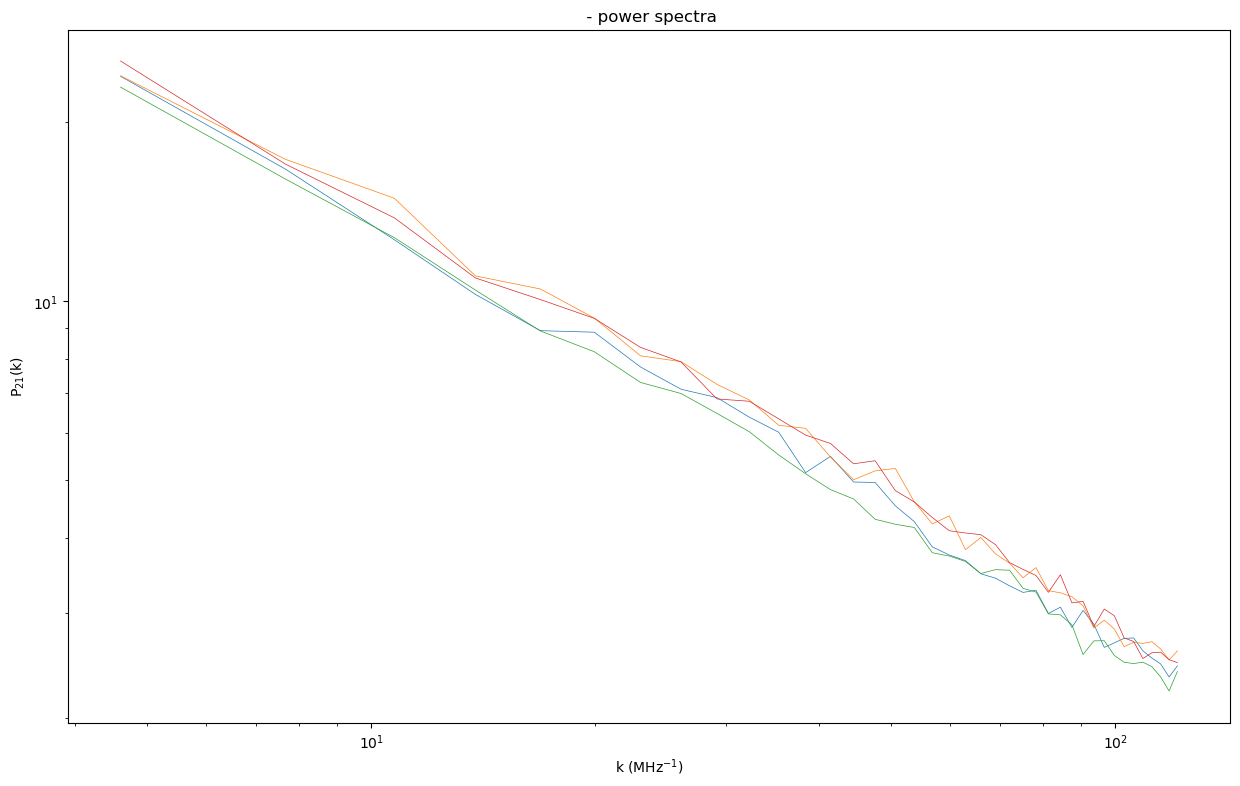

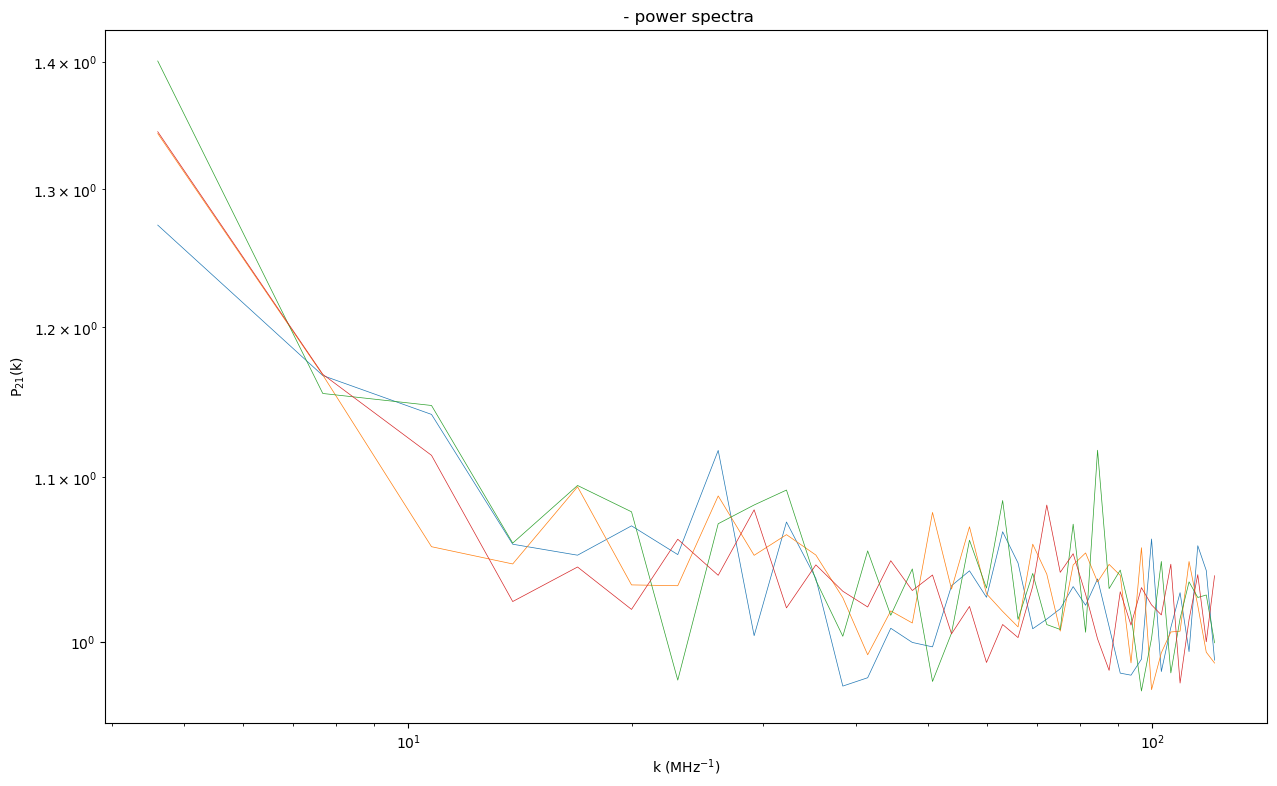

<Figure size 1500x900 with 0 Axes>

In [3]:
ps_sub = ps/psn_m[0]
ps1_sub = ps1/psn_m[0]
base.plot_power_spectra(ps_sub[:4], ks[:4], params[:4], showplots=True, saveplots = False)
base.plot_power_spectra(ps1_sub[:4], ks1[:4], params1[:4], showplots=True, saveplots = False)


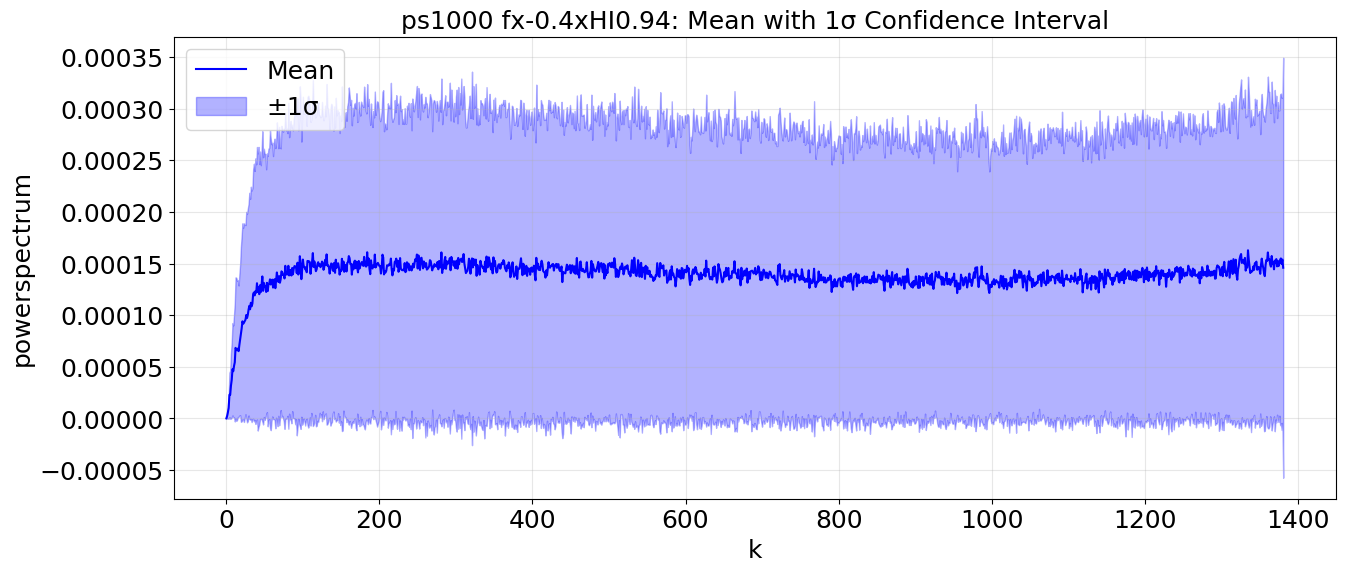

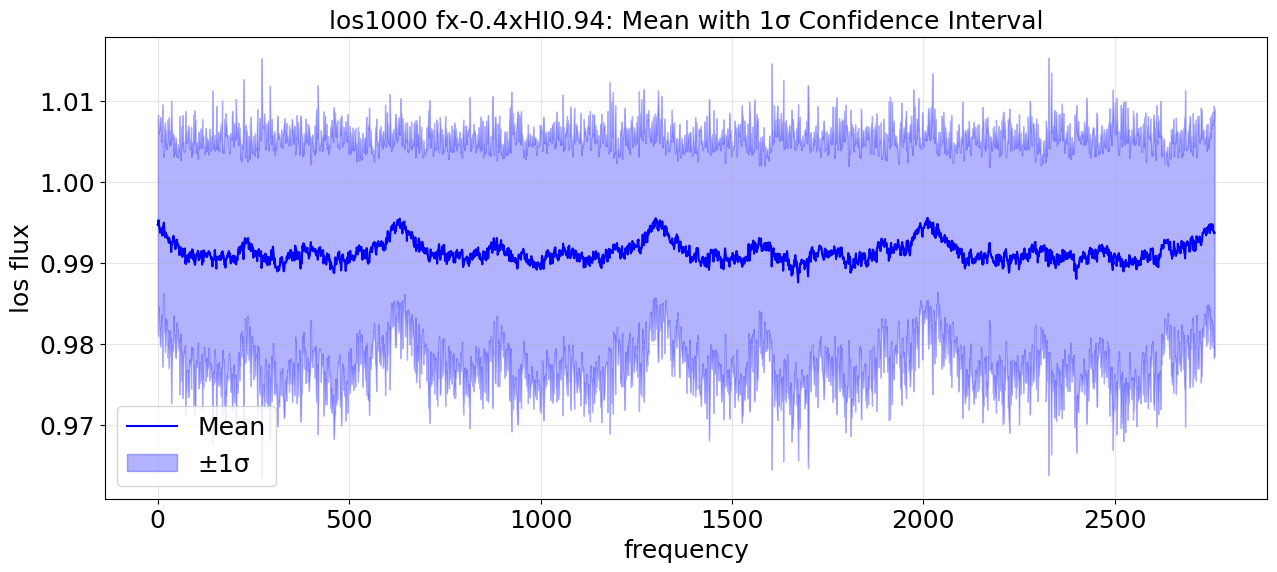

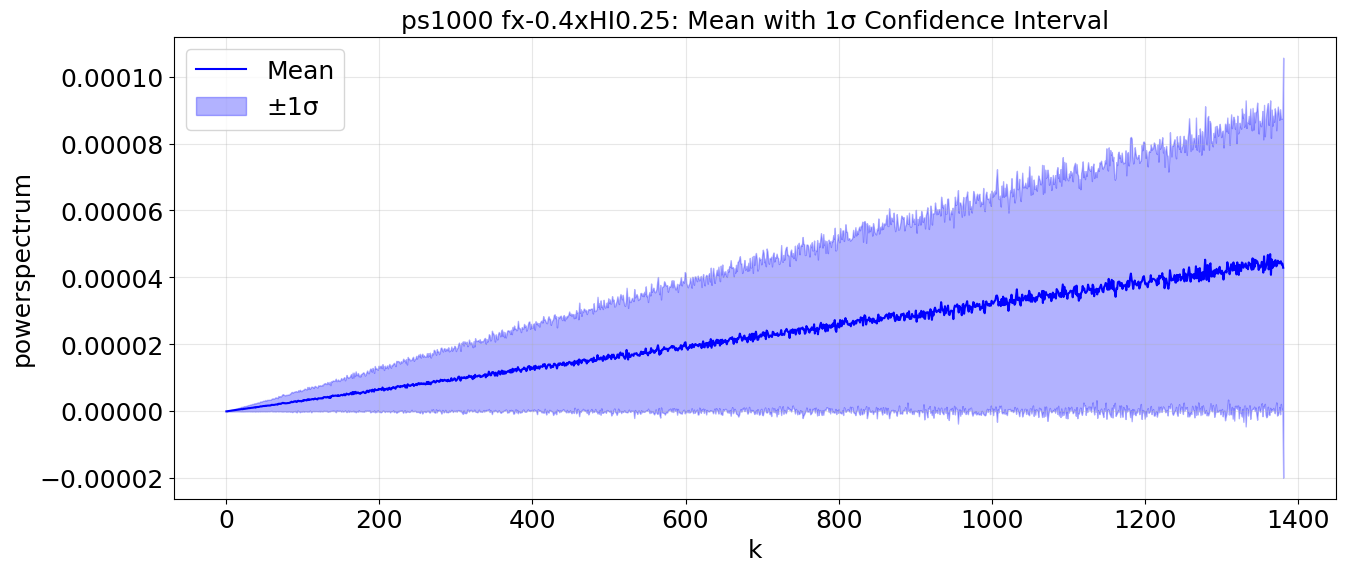

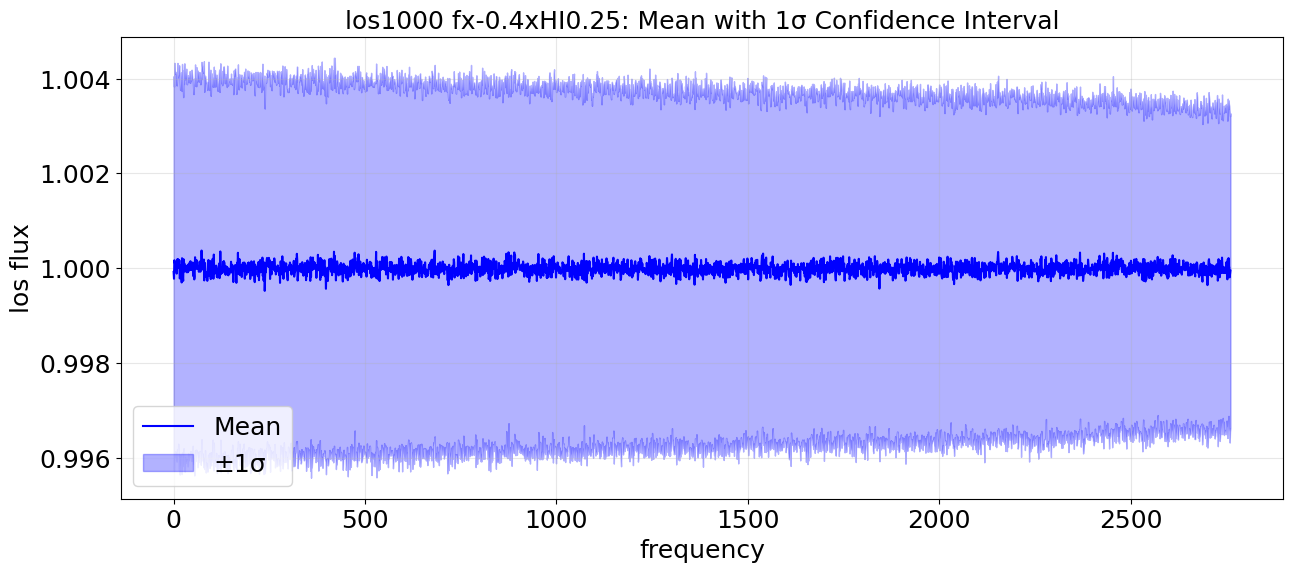

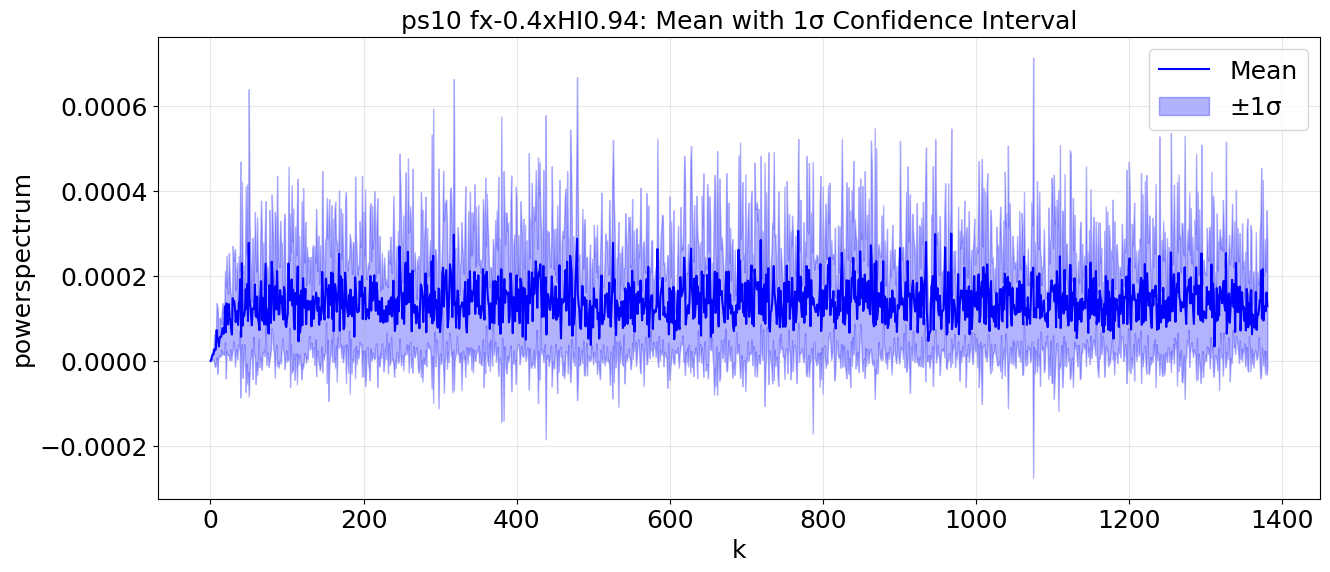

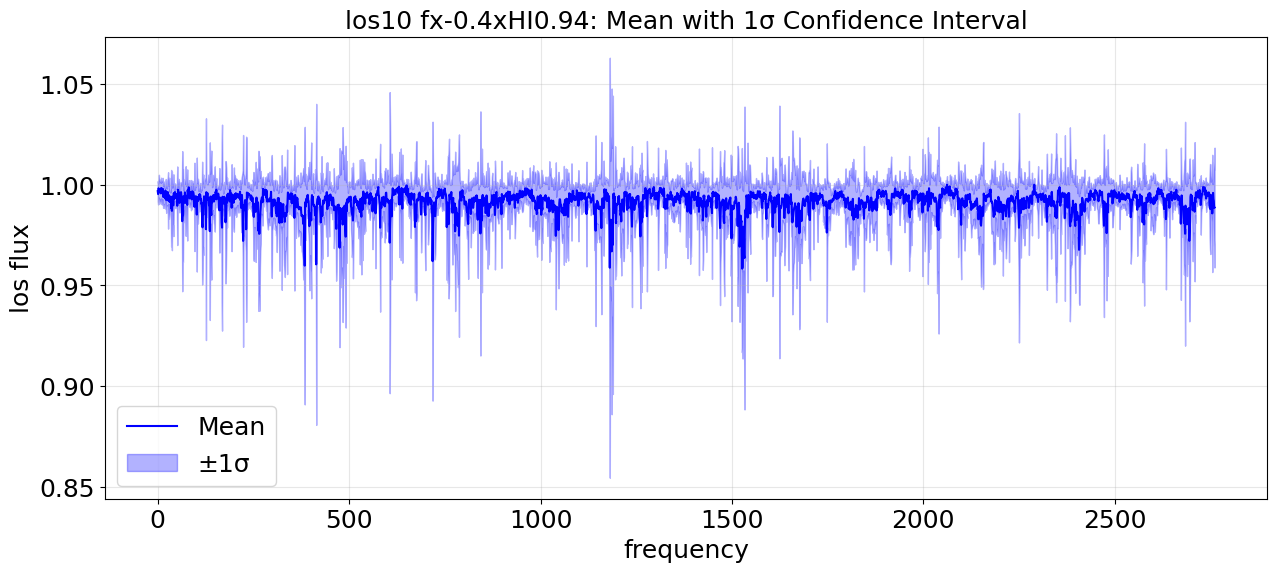

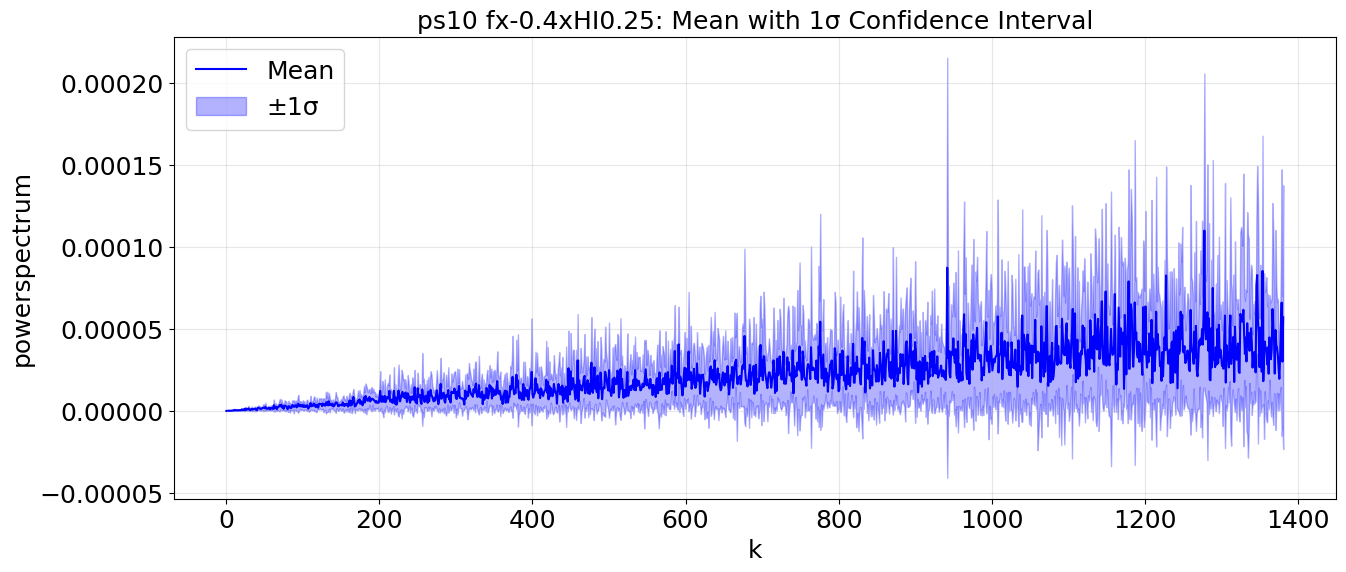

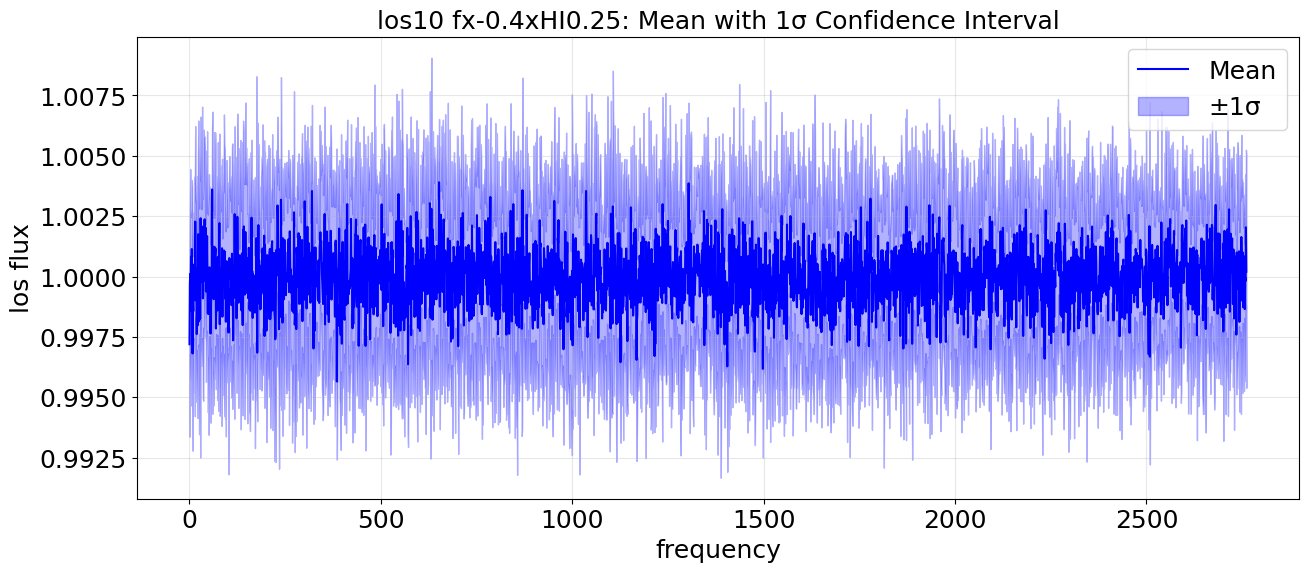

In [37]:
def plot(ps, title='', xlabel='', ylabel=''):# Create DataFrame from ps array with proper indexing
    df_ps = pd.DataFrame(ps)

    # If you want to verify the DataFrame was created correctly
    #print(f"DataFrame shape: {df_ps.shape}")
    #print("\nFirst few rows:")
    #print(df_ps.describe())

    # Calculate mean and standard deviation across all samples
    mean_ps = df_ps.mean(axis=0)
    std_ps = df_ps.std(axis=0)

    # Create the plot
    plt.figure(figsize=(15,6))

    # Plot mean line
    plt.plot(mean_ps, color='blue', label=f'Mean')

    # Add shaded region for 1-sigma
    plt.fill_between(range(len(mean_ps)), 
                    mean_ps - std_ps,  # Lower bound
                    mean_ps + std_ps,  # Upper bound
                    alpha=0.3,         # Transparency
                    color='blue',
                    label='±1σ')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{title}: Mean with 1σ Confidence Interval')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot(ps, title='ps1000 fx-0.4xHI0.94', xlabel='k', ylabel='powerspectrum')
plot(los, title='los1000 fx-0.4xHI0.94', xlabel='frequency', ylabel='los flux')
plot(ps1, title='ps1000 fx-0.4xHI0.25', xlabel='k', ylabel='powerspectrum')
plot(los1, title='los1000 fx-0.4xHI0.25', xlabel='frequency', ylabel='los flux')
plot(ps[:10], title='ps10 fx-0.4xHI0.94', xlabel='k', ylabel='powerspectrum')
plot(los[:10], title='los10 fx-0.4xHI0.94', xlabel='frequency', ylabel='los flux')
plot(ps1[:10], title='ps10 fx-0.4xHI0.25', xlabel='k', ylabel='powerspectrum')
plot(los1[:10], title='los10 fx-0.4xHI0.25', xlabel='frequency', ylabel='los flux')


Combined data shape: (1000, 2762)
Combined parameters shape: (1000, 2)


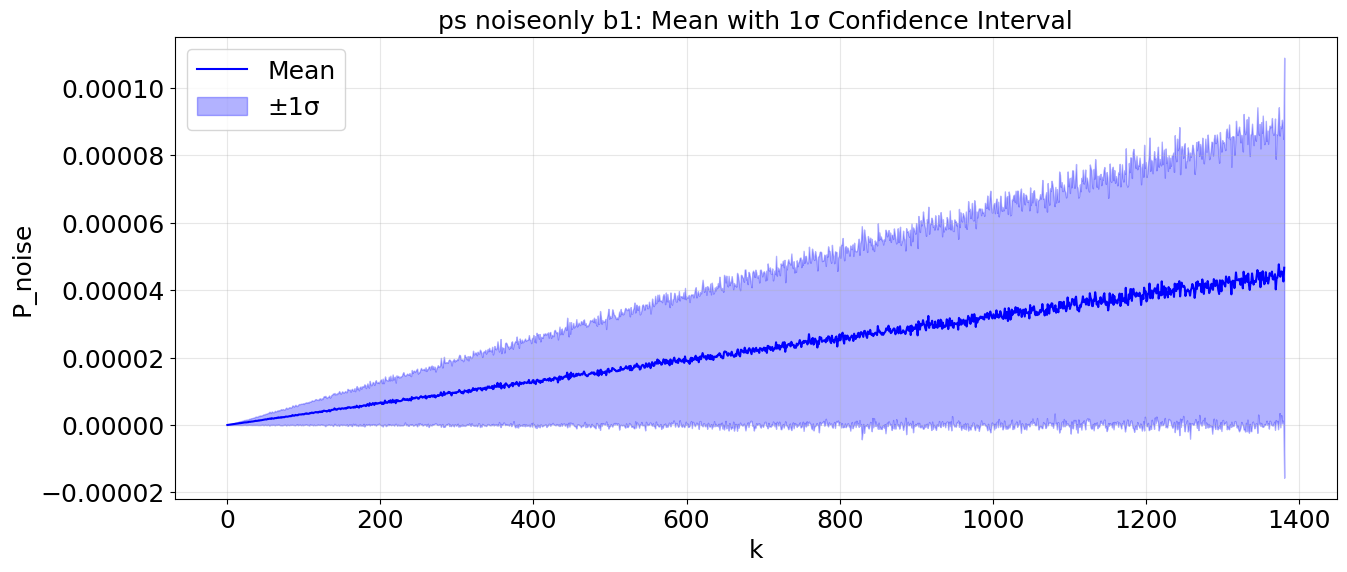

min-max range: -999--999


ValueError: x and y must have same first dimension, but have shapes (1381,) and (0, 1382)

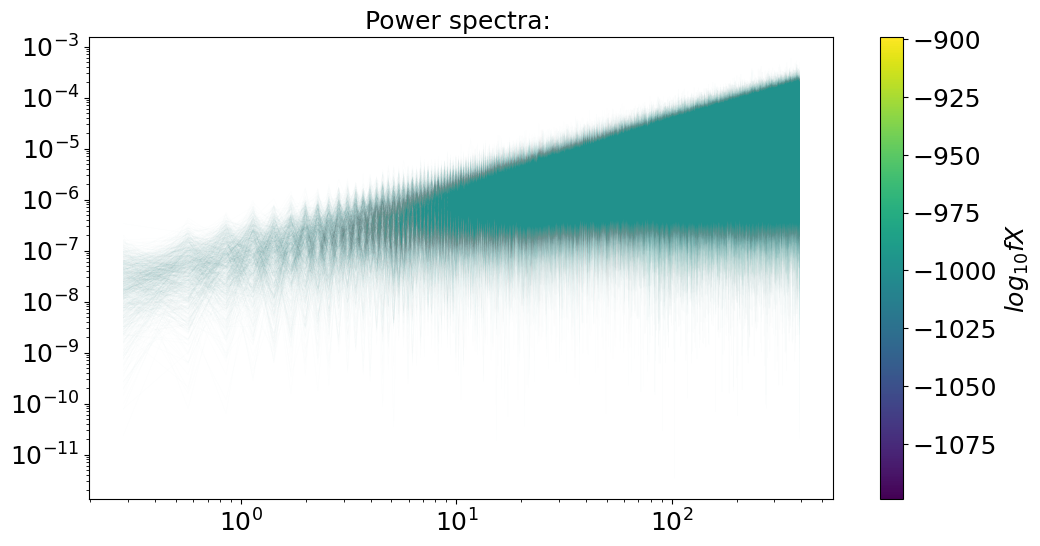

In [41]:
# Load different insteance of noise only sightlines . Take their PS and observe variation.
(paramsnb1, freqnb1, losnb1, psnb1, ksnb1) = load_dataset(["../data/21cmFAST_los/F21_noisy/F21_noiseonly_21cmFAST_200Mpc_z6.0_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"], psbatchsize=1)
plot(psnb1, title='ps noiseonly b1', xlabel='k', ylabel='P_noise')
base.plot_power_spectra(psnb1, ksnb1, paramsnb1, psn1000, saveplots=False, showplots=True)
base.bin_ps_data()


In [4]:
import F21DataLoader as dl
import f21_predict_base as base
import instrumental_features
import PS1D
import numpy as np

import importlib
importlib.reload(dl)
importlib.reload(base)
importlib.reload(instrumental_features)
importlib.reload(PS1D)

def load_los_data(datafiles):
    # Lists to store combined data
    # Create processor with desired number of worker threads
    processor = dl.F21DataLoader(max_workers=1, psbatchsize=1, skip_ps=True, limitsamplesize=10, scale_ps=True)
        
    # Process all files and get results 
    results = processor.process_all_files(datafiles)
        
    # Access results
    print(f'{results.keys()}')
    all_los = results['los']
    all_freq = results['freq_axis']
    all_params = results['params']
    #plot_los(all_ps[0], freq_axis)
    print(f"sample params:{all_params[0]}")
    print(f"Loaded data shapes: {all_los.shape} {all_freq.shape} {all_params.shape}")
    base.plot_los(all_los[:1], all_freq[0,:], showplots=True, saveplots = False)
    
    # Combine all data
    los_combined = np.array(all_los)
    params_combined = np.array(all_params)

    print(f"\nCombined data shape: {los_combined.shape}")
    print(f"Combined parameters shape: {params_combined.shape}")
    return (params_combined, all_freq, los_combined)


In [18]:
# main
(params, freq, los) = load_los_data(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"])
#(params1, freq1, los1) = load_los_data(["../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.25_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat"])

(params_t, freq_axis, los_t) = (params[0], freq[0], los[0])
Nbins = len(freq_axis)
#print('Number of pixels (original): %d' % Nbins)
#print(f'original freq: {freq_axis[:10]}')
freq_uni, _ = instrumental_features.uni_freq(freq_axis, np.array([freq_axis]))

#print(f'freq_uni length: {len(freq_uni)}')
#print(f'freq_uni: {freq_uni[:10]}')
freq_smooth, _ = instrumental_features.smooth_fixedbox(freq_uni,freq_uni, 8) # 8kHz Spectral resoluti
#print(f'freq_smooth length: {len(freq_smooth)}')
#print(f'freq_smooth: {freq_smooth[:10]}')
bandwidth = (freq_smooth[-1]-freq_smooth[0])/1e6
#print('Number of pixels (smoothed): %d' % len(freq_smooth))
#print('Bandwidth = %.2fMHz' % bandwidth)

#n_kbins = int((len(freq_smooth)/2+1))

signal_ori = instrumental_features.transF(los_t)
print(f'signal_ori length: {len(signal_ori)}')
print(f'signal_ori: {signal_ori[:10]}')
freq_uni,signal_uni = instrumental_features.uni_freq(freq_axis, np.array([signal_ori])) #Interpolate signal to uniform frequency grid
print(f'freq_uni length: {len(freq_uni)}')
print(f'freq_uni: {freq_uni[:10]}')
print(f'signal_uni length: {len(signal_uni[0])}')
print(f'signal_uni: {signal_uni[0,:10]}')

curr_los=signal_uni[0]
freq_smooth,signal_smooth = instrumental_features.smooth_fixedbox(freq_uni,curr_los, 8) #Incorporate spectral resolution of telescope
print(f'freq_smooth length: {len(freq_smooth)}')
print(f'freq_smooth: {freq_smooth[:10]}')
print(f'signal_smooth length: {len(signal_smooth)}')
print(f'signal_smooth: {signal_smooth[:10]}')
base.plot_los(np.array([signal_ori[:2761]+0.05, signal_smooth]), freq_smooth, showplots=True, saveplots = False)

freq_smooth = freq_smooth[:-1]
los = signal_smooth[:-1]
# Calculate the power spectrum
ks,ps = PS1D.get_P(los,bandwidth, scaled=True) #Calculate 1D power spectrum
base.plot_single_power_spectrum(ps, ks, showplots=True, saveplots=False, label="Unbinned PS of Smoothed Signal")
ks_bin, ps_bin = logbin_power_spectrum_by_k(np.array([ks]), np.array([ps]))
base.plot_single_power_spectrum( ps_bin[0], ks_bin[0], showplots=True, saveplots=False, label="Log-binned PS of Smoothed Signal")
print(f"Binned PS: ks= {ks_bin}\nps= {ps_bin}")
ks_linbin, ps_linbin = bin_ps_data(np.array([ps]), np.array([ks]), 16, 100)
base.plot_single_power_spectrum( ps_linbin[0], ks_linbin[0], showplots=True, saveplots=False, label="Linear-binned PS of Smoothed Signal")
base.plot_power_spectra(np.vstack((ps_linbin[0], ps_bin[0])), np.vstack((ks_linbin[0], ks_bin[0])), np.vstack((params[0], params[0])), psn=psn1000_bin)
print(f"Binned PS: ks= {ks_linbin}\nps= {ps_linbin}")


NameError: name 'load_los_data' is not defined

In [20]:
import numpy as np
import matplotlib.colors as clr
import f21_predict_base as base
import importlib

importlib.reload(base)

def load_training_data(filename):
    import csv
    from collections import defaultdict

    # Dictionary to store grouped data
    grouped_data = defaultdict(list)

    # Load the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the header

        # Identify the last two columns as keys
        key1_index = len(header) - 2
        key2_index = len(header) - 1

        # Read the data and group by the last two columns
        for row in reader:
            key1 = float(row[key1_index])
            key2 = 5.0*(float(row[key2_index])-0.8)
            values = list(map(float, row[:-2]))  # Convert all but the last two columns to float
            grouped_data[(key1, key2)].append(values)

    # Calculate the mean for each group
    mean_data = {}
    for keys, values in grouped_data.items():
        mean_values = [sum(col) / len(col) for col in zip(*values)]
        mean_data[keys] = mean_values

    return mean_data

def print_sample(data):
    # Print the unique keys followed by the means
    for key, group in data.iterrows():
        if key[0] > 0.24 and key[0] < 0.26:
            print("Key:", key)
            print("Means:")
            print(group)
            print("---")

def initplt():
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.fontsize'] = 18

def decide_alpha(num_ps):
    if num_ps >= 1000: return 0.01
    if num_ps <= 10: return 1
    logn = np.log10(num_ps)
    return 1 - (logn - 1) * 0.495

def filter_data(data, keyind, min, max):
    stats=[]
    params=[]

    for k, v in data.items():
        if min < k[keyind] < max:
            stats.append(v)
            params.append(k)
    stats = np.array(stats)
    params = np.array(params)
    return stats, params


min-max range: -4.0-0.9999999999999998


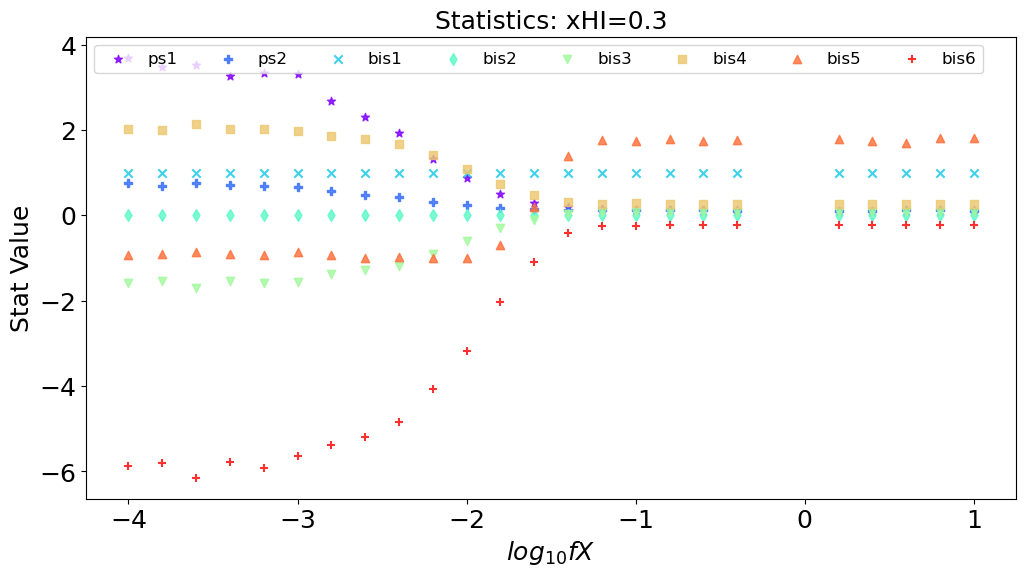

min-max range: 0.004162702709436417-0.9957664012908936


<Figure size 1200x600 with 0 Axes>

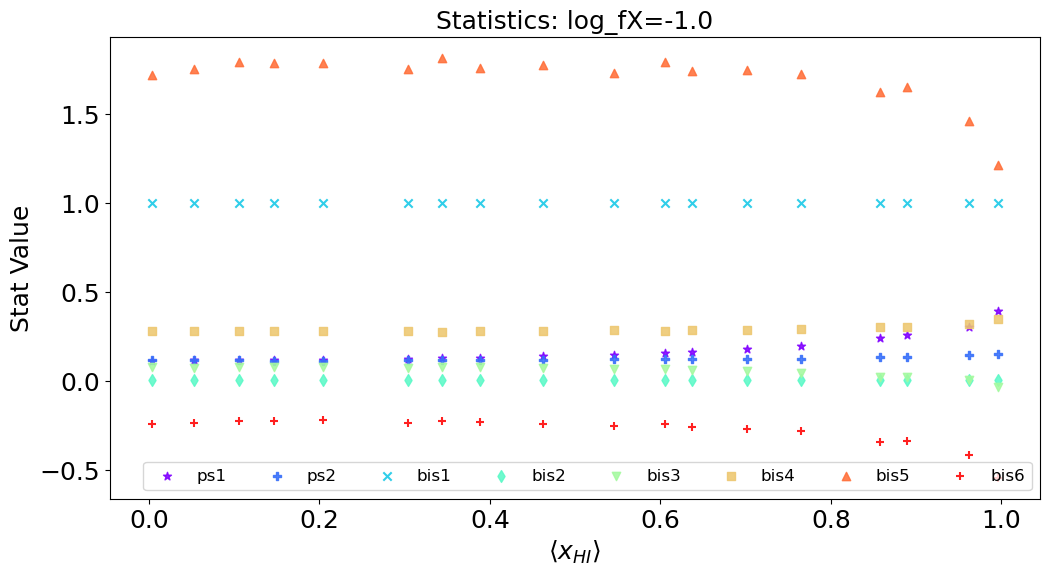

min-max range: 0.004337502643465996-0.9993957877159119


<Figure size 1200x600 with 0 Axes>

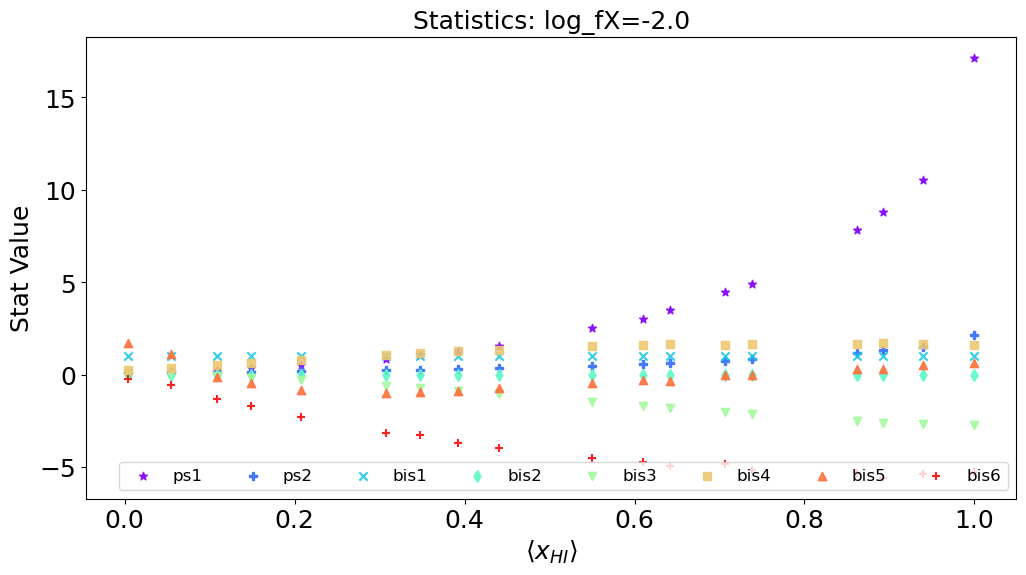

<Figure size 1200x600 with 0 Axes>

In [23]:
# Load the data and compute means
data = load_training_data('output/f21_ps_xgb_train_test_uGMRT_t500h_b1_20241219035942_ps_and_stats_default_xgbreg/all_training_data.csv')
# Get filtered data for xHI=0.25
stats, params = filter_data(data, 0, 0.29, 0.31)
base.plot_stats(stats, params, colorind=1, saveplots=False, showplots=True, label='xHI=0.3')

stats, params = filter_data(data, 1, -1.1, -0.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-1.0')

stats, params = filter_data(data, 1, -2.1, -1.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-2.0')


min-max range: -4.0-0.9999999999999998


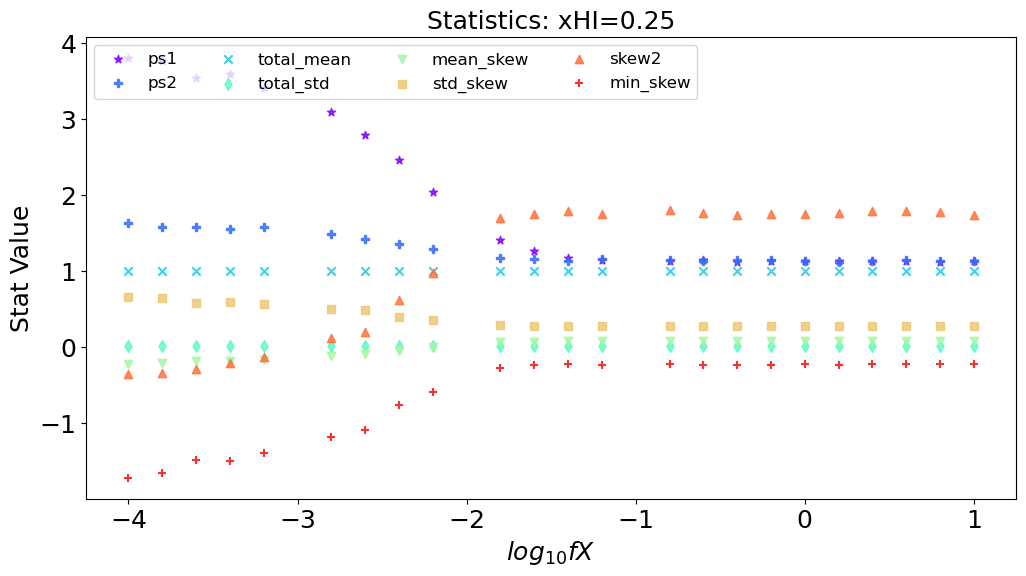

min-max range: 0.004162702709436417-0.9957664012908936


<Figure size 1200x600 with 0 Axes>

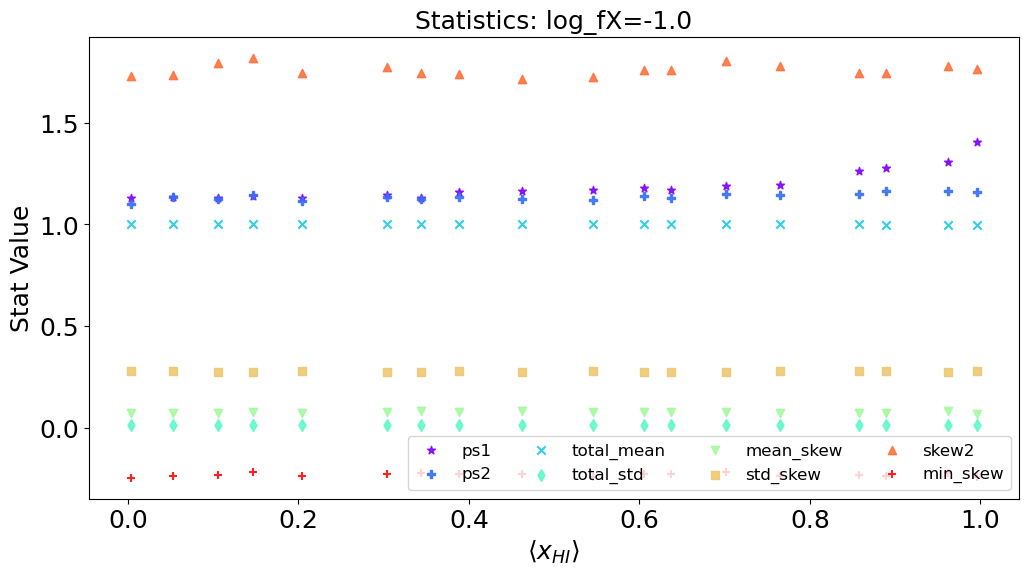

min-max range: 0.004337502643465996-0.9993957877159119


<Figure size 1200x600 with 0 Axes>

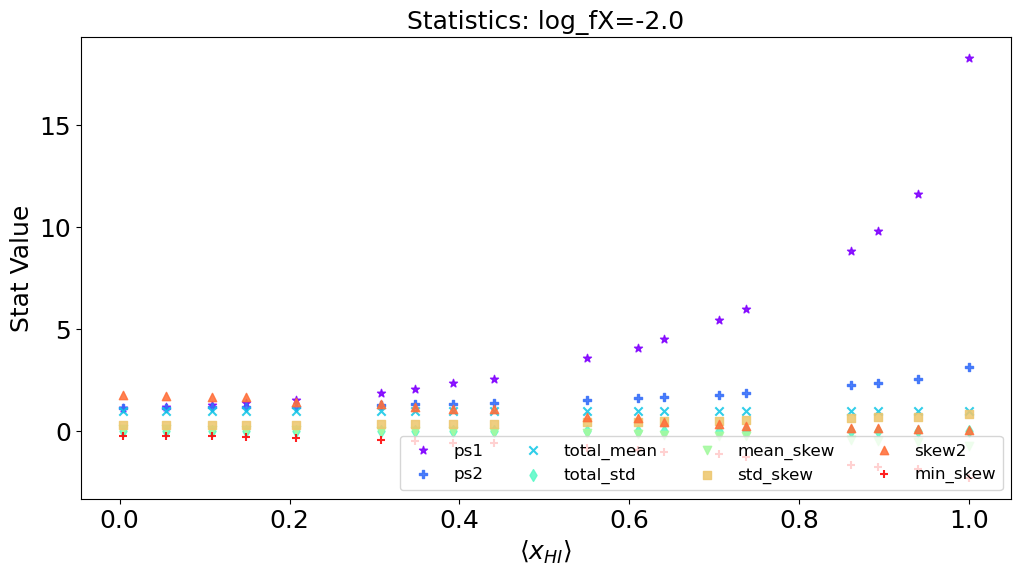

<Figure size 1200x600 with 0 Axes>

In [210]:
# Load the data and compute means
data = load_training_data('output/f21_ps_xgb_train_test_uGMRT_t50h_b1_20241219133354_ps_and_stats_default_xgbreg/all_training_data.csv')
# Get filtered data for xHI=0.25
stats, params = filter_data(data, 0, 0.24, 0.26)
base.plot_stats(stats, params, colorind=1, saveplots=False, showplots=True, label='xHI=0.25')

stats, params = filter_data(data, 1, -1.1, -0.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-1.0')

stats, params = filter_data(data, 1, -2.1, -1.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-2.0')


min-max range: -4.0-0.9999999999999998


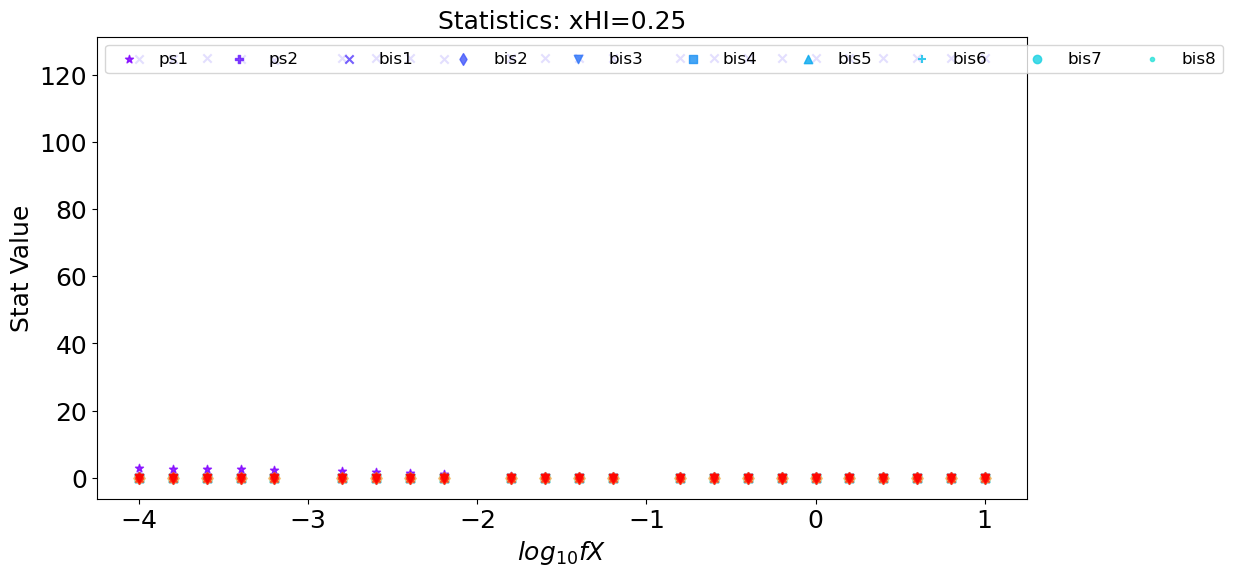

min-max range: 0.004162702709436417-0.9957664012908936


<Figure size 1200x600 with 0 Axes>

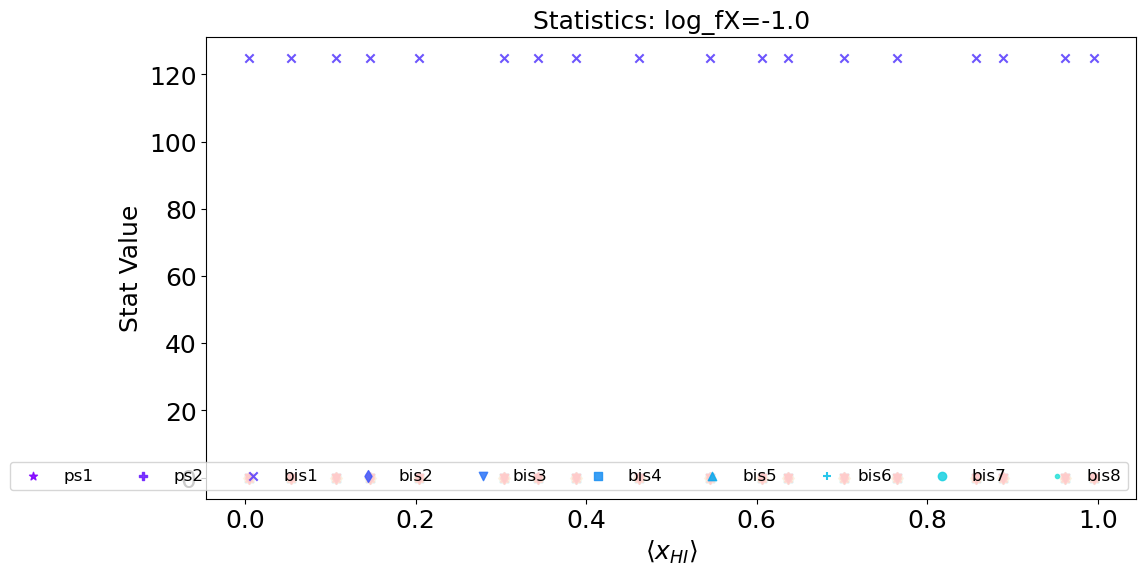

min-max range: 0.004337502643465996-0.9993957877159119


<Figure size 1200x600 with 0 Axes>

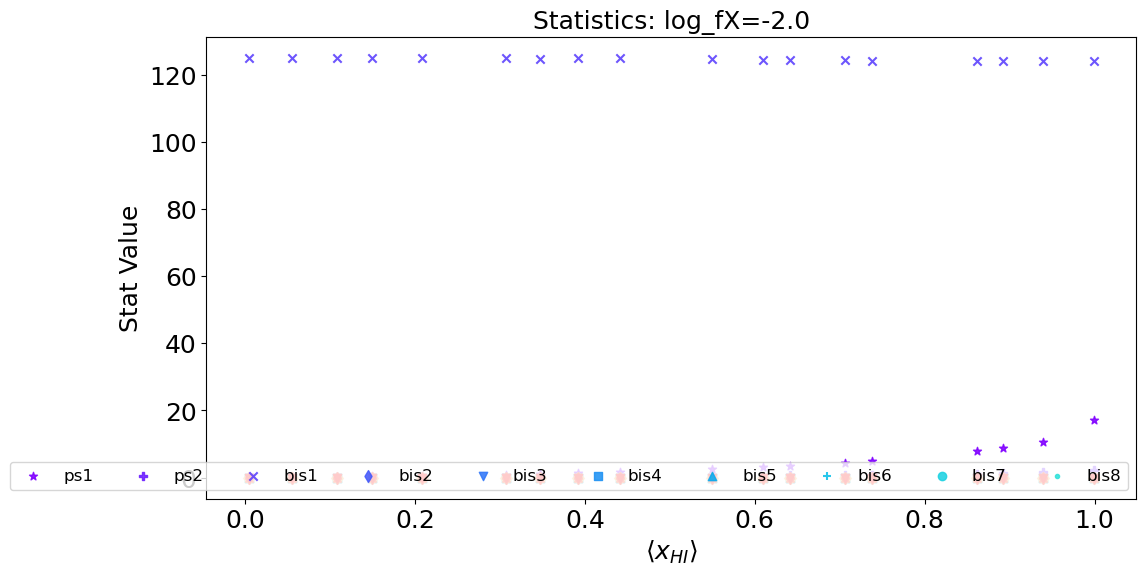

<Figure size 1200x600 with 0 Axes>

In [217]:
# Load the data and compute means
data = load_training_data('output/f21_ps_xgb_train_test_uGMRT_t500h_b1_20241219143543/all_training_data.csv')
# Get filtered data for xHI=0.25
stats, params = filter_data(data, 0, 0.24, 0.26)
base.plot_stats(stats, params, colorind=1, saveplots=False, showplots=True, label='xHI=0.25')

stats, params = filter_data(data, 1, -1.1, -0.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-1.0')

stats, params = filter_data(data, 1, -2.1, -1.9)
base.plot_stats(stats, params, colorind=0, saveplots=False, showplots=True, label='log_fX=-2.0')

In [131]:
import numpy as np

# Example: NumPy array of tuples
array_of_tuples = np.array([(1, 2, 3), (4, 5, 6), (7, 8, 9)])
print(array_of_tuples)

# Convert to 2D NumPy array
array_2d = np.array(array_of_tuples)

# Alternatively, using np.vstack (useful for non-uniform tuple lengths)
# array_2d = np.vstack(array_of_tuples)

print("2D Array:")
print(array_2d)


[[1 2 3]
 [4 5 6]
 [7 8 9]]
2D Array:
[[1 2 3]
 [4 5 6]
 [7 8 9]]


Shape of original signal: (10000, 3)
Shape of recovered signal: (10000, 3)


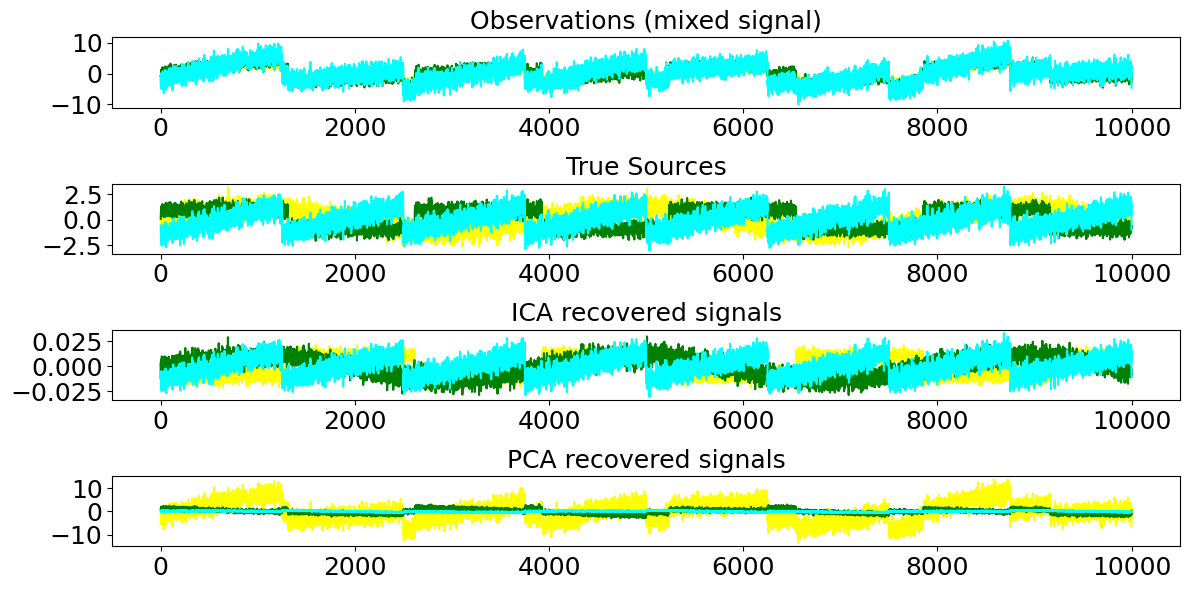

In [45]:
# importing libraries
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
# generating sample data
np.random.seed(20)
numberOfSamples = 10000
timeRange = np.linspace(0, 8, numberOfSamples)

# Sinusoidal signal
signal1 = np.sin(2 * timeRange) 

# Square signal
signal2 = np.sign(np.sin(3 * timeRange)) 

# Saw-tooth signal
signal3 = signal.sawtooth(2 * np.pi * timeRange) 
signalSummation = np.c_[signal1, signal2, signal3]

# Adding some noise
signalSummation += 0.4 * \
	np.random.normal(size=signalSummation.shape) 

# Standardization of data
signalSummation /= signalSummation.std(axis=0) 
# Mixing the data
mixMatrix = np.array(
	[[1, 1, 1], [0.8, 2, 1.2], [1.6, 1.2, 2.4]]) 

# Generate observations
obsvGenerate = np.dot(signalSummation, mixMatrix.T) 

# Fitting ICA and PCA models
# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
print(f"Shape of original signal: {obsvGenerate.shape}")
signalRecont = ica.fit_transform(obsvGenerate) # Reconstruct signals
print(f"Shape of recovered signal: {signalRecont.shape}")
mixMatrixEst = ica.mixing_ # Get estimated mixing matrix
assert np.allclose(obsvGenerate, np.dot(
	signalRecont, mixMatrixEst.T) + ica.mean_)
# compute PCA
pca = PCA(n_components=3)
# Reconstruct signals based on orthogonal components
orthosignalrecont = pca.fit_transform(obsvGenerate)

# Plot results
plt.figure()
models = [obsvGenerate, signalSummation, signalRecont, orthosignalrecont]
names = ["Observations (mixed signal)",
		"True Sources", "ICA recovered signals", 
		"PCA recovered signals",
		]
colors = ["yellow", "green", "cyan"]

for ii, (model, name) in enumerate(zip(models, names), 1):
	plt.subplot(4, 1, ii)
	plt.title(name)
	for sig, color in zip(model.T, colors):
		plt.plot(sig, color=color)

plt.tight_layout()
plt.show()


norm_los shape: (5, 1382)
Recovered shape: (1382, 2)


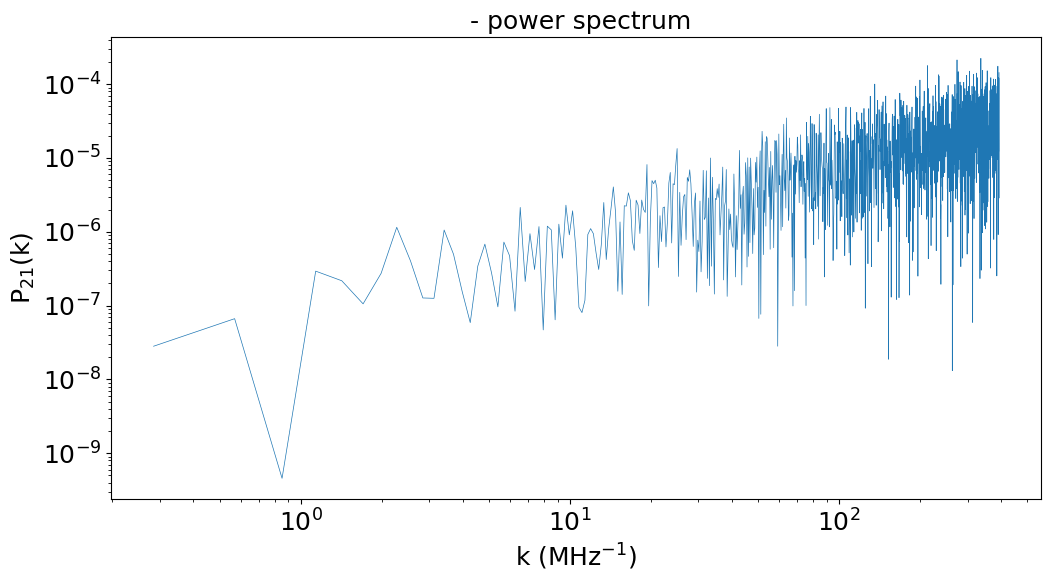

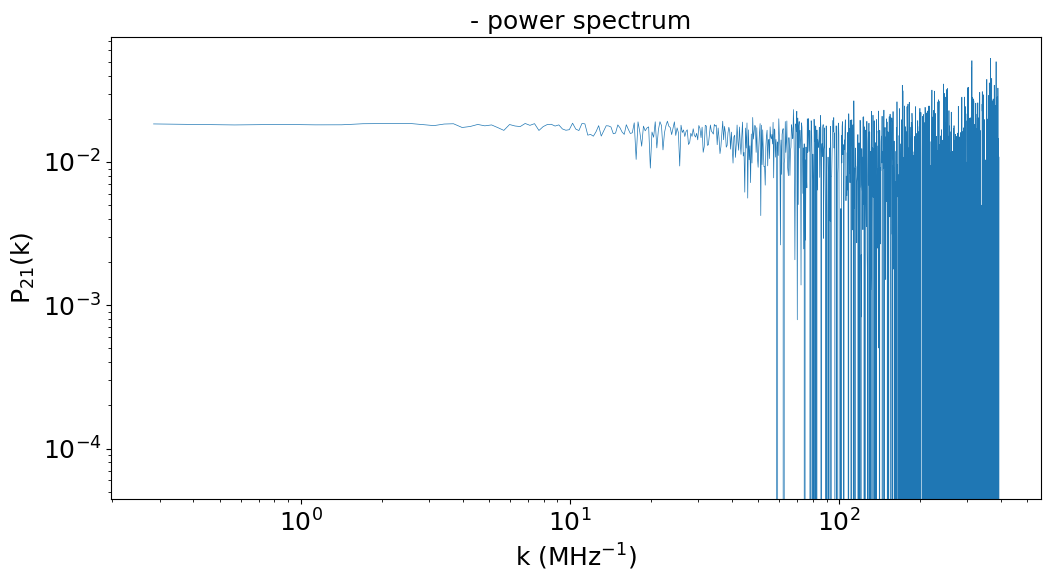

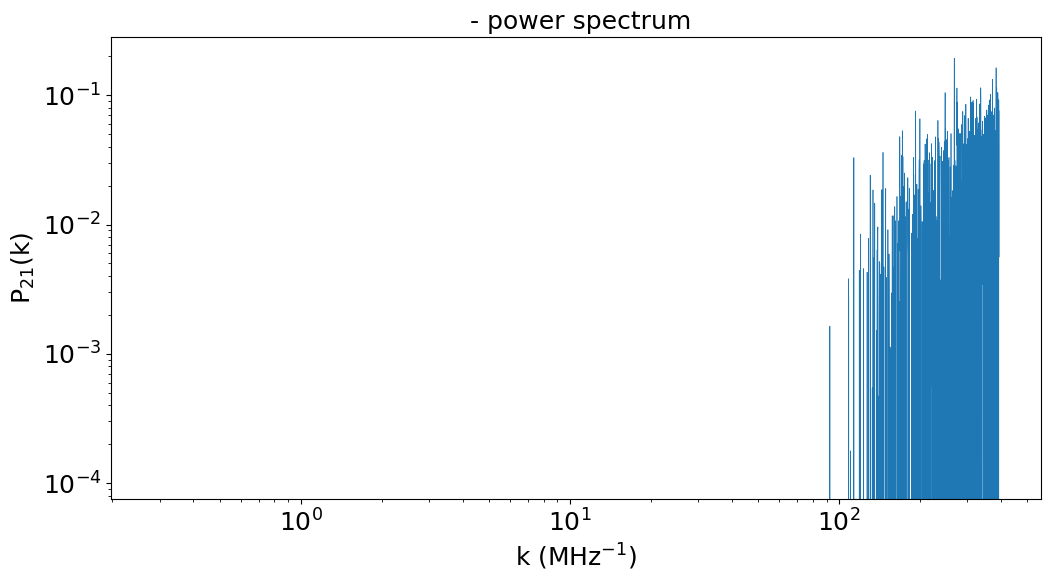

'\nmixMatrixEst = ica.mixing_ # Get estimated mixing matrix\nassert np.allclose(los, np.dot(\n\tsignalRecont, mixMatrixEst.T) + ica.mean_)\n\n# compute PCA\npca = PCA(n_components=3)\n# Reconstruct signals based on orthogonal components\northosignalrecont = pca.fit_transform(los)\n\nplt.figure()\nmodels = [los, signalRecont, orthosignalrecont]\nnames = ["Observations (mixed signal)",\n        "ICA recovered signals", \n        "PCA recovered signals",\n        ]\ncolors = ["yellow", "green", "cyan"]\n \nfor ii, (model, name) in enumerate(zip(models, names), 1):\n    plt.subplot(3, 1, ii)\n    plt.title(name)\n    for sig, color in zip(model.T, colors):\n        plt.plot(sig, color=color)\n \nplt.tight_layout()\nplt.show()\n'

<Figure size 1200x600 with 0 Axes>

In [60]:
   
# importing libraries
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from sklearn import preprocessing
import f21_predict_base as base
import importlib

importlib.reload(base)

norm_los = preprocessing.normalize(los1[:5])
print(f"norm_los shape: {norm_los.shape}")
# Compute ICA
ica = FastICA(n_components=2, whiten="arbitrary-variance")
signalRecont = ica.fit_transform(norm_los.T) # Reconstruct signals

print(f'Recovered shape: {signalRecont.shape}')
base.plot_single_los(los1[0], freq[0], showplots=True, saveplots=False)
base.plot_single_los(signalRecont.T[0], freq[0], showplots=True, saveplots=False)
base.plot_single_los(signalRecont.T[1], freq[0], showplots=True, saveplots=False)

"""
mixMatrixEst = ica.mixing_ # Get estimated mixing matrix
assert np.allclose(los, np.dot(
	signalRecont, mixMatrixEst.T) + ica.mean_)

# compute PCA
pca = PCA(n_components=3)
# Reconstruct signals based on orthogonal components
orthosignalrecont = pca.fit_transform(los)

plt.figure()
models = [los, signalRecont, orthosignalrecont]
names = ["Observations (mixed signal)",
        "ICA recovered signals", 
        "PCA recovered signals",
        ]
colors = ["yellow", "green", "cyan"]
 
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
 
plt.tight_layout()
plt.show()
"""

